# Мастерская 2 — Маркетинг интернет-магазина

Интернет-магазин собирает историю покупателей, проводит рассылки предложений и 
планирует будущие продажи. Для оптимизации процессов надо выделить пользователей 
которые готовы совершить покупку в ближайшее врем

Нам предоставлены данные по истории покупателей. У нас есть история того как тот или иной покупатель реагировал на коммуникацию, которая проводилась. Под коммуникацией мы имеем ввиду, например, промо-предложение, направленное в смс / push сообщении. По каждому товару проставлена категория, которая помогает определить насколько покупатель “латентен” (предпочтителен) к этой группе товаров.

Наша главная **цель** -  создать модель прогнозирования покупки каждым покупателем в ближайшие 90 дней. Это нужно для улучшения работы и повышения эффективности марктетинговых компаний.

### Описание данных

* ```apparel-purchases```

Данные о покупках клиентов по дням и по товарам. В каждой записи покупка
определенного товара, его цена, количество штук.

В таблице есть списки идентификаторов, к каким категориям относится товар. Часто
это вложенные категории (например автотовары-аксессуары-освежители), но также может
включать в начале списка маркер распродажи или маркер женщинам/мужчинам. Нумерация категорий сквозная для всех уровней, то есть 44 на второй позиции списка или на третьей – это одна и та же категория. Иногда дерево категорий обновляется, поэтому могут меняться вложенности, например ['4', '28', '44', '1594'] или ['4', '44', '1594']. **Необходимо обработать такие случаи**.

```client_id``` - идентификатор клиента 

```quantity``` - количество единиц товара

```price``` - цена товара

```category_ids``` - идентификаторы категорий

```date``` - дата покупки

```message_id``` - идентификатор сообщения из рассылки

* ```apparel-messages```

Рассылки, которые были отправлены клиентам из таблицы покупок.

```bulk_campaign_id``` -  идентификатор рассылки

```client_id``` - идентификатор клиента

```message_id```  - идентификатор сообщения

```event``` - действие с сообщением (отправлено, открыто, покупка…)

```channel``` - канал рассылки

```date``` - дата действия

```created_at``` - дата-время полностью

* target

```client_id``` - идентификатор клиента

```target``` - клиент совершил покупку в целевом периоде

* full_campaign_daily_event

Агрегация общей базы рассылок по дням и типам событий

```date``` - дата

```bulk_campaign_id``` - идентификатор рассылки

```count_event*``` - общее количество каждого события event

```nunique_event*``` - количество уникальных client_id в каждом событии

*в именах колонок найдете все типы событий event

* full_campaign_daily_event_channel

Агрегация по дням с учетом событий и каналов рассылки

```date``` - дата

```bulk_campaign_id``` - идентификатор рассылки

```count_event*_channel``` - общее количество каждого события по каналам

```nunique_event*_channel``` - количество уникальных client_id по событиям и каналам

*в именах колонок есть все типы событий event и каналов рассылки channel

## Загрузка

In [13]:
!pip install phik -q

In [14]:
from ast import literal_eval
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec

from sklearn.preprocessing import MultiLabelBinarizer
from phik.report import plot_correlation_matrix

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    MinMaxScaler,
    LabelEncoder
)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score

import phik
import time
import joblib
import shap

Ссылка на датасеты
https://disk.yandex.ru/d/cIfdQTAPMQ8XxA

In [15]:
try:
    messages = pd.read_csv('datasets/apparel-messages.csv', parse_dates=['date','created_at'])
    purchases = pd.read_csv('datasets/apparel-purchases.csv', parse_dates=['date'])
    target = pd.read_csv('datasets/apparel-target_binary.csv')
    event = pd.read_csv('datasets/full_campaign_daily_event.csv', parse_dates=['date'])
    channel = pd.read_csv('datasets/full_campaign_daily_event_channel.csv', parse_dates=['date'])

except:
    messages = pd.read_csv('/datasets/apparel-messages.csv', parse_dates=['date','created_at'])
    purchases = pd.read_csv('/datasets/apparel-purchases.csv', parse_dates=['date'])
    target = pd.read_csv('/datasets/apparel-target_binary.csv')
    event = pd.read_csv('/datasets/full_campaign_daily_event.csv', parse_dates=['date'])
    channel = pd.read_csv('/datasets/full_campaign_daily_event_channel.csv', parse_dates=['date'])


In [16]:
 def data_head_desc_info(data):
    try:
        display('Первые 3 строки:')
        display(data.head(3))
        display('Описание данных:')
        display(data.describe(include = "all"))
        display('Общая информацию о датафрейме')
        display(data.info())
        display('Количество пропусков')
        display(data.isna().sum())
    except:
        return 'Проверьте параметры'

#### messages

In [18]:
data_head_desc_info(messages)

'Первые 3 строки:'

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49


'Описание данных:'

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
count,1.273980e+07,1.273980e+07,12739798,12739798,12739798,12739798,12739798
unique,NaN,NaN,9061667,11,2,NaN,NaN
top,NaN,NaN,1515915625489095763-6251-6311b13a4cf78,send,mobile_push,NaN,NaN
freq,NaN,NaN,1454,9058196,7512156,NaN,NaN
mean,1.160459e+04,1.515916e+18,NaN,NaN,NaN,2023-06-05 02:46:08.357990400,2023-06-05 13:58:11.168689408
min,5.480000e+02,1.515916e+18,NaN,NaN,NaN,2022-05-19 00:00:00,2022-05-19 00:14:20
25%,8.746000e+03,1.515916e+18,NaN,NaN,NaN,2022-12-19 00:00:00,2022-12-19 12:46:30
50%,1.351600e+04,1.515916e+18,NaN,NaN,NaN,2023-07-20 00:00:00,2023-07-20 17:21:54
75%,1.415800e+04,1.515916e+18,NaN,NaN,NaN,2023-11-21 00:00:00,2023-11-21 18:13:05
max,1.465700e+04,1.515916e+18,NaN,NaN,NaN,2024-02-15 00:00:00,2024-02-15 23:58:40


'Общая информацию о датафрейме'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype         
---  ------            -----         
 0   bulk_campaign_id  int64         
 1   client_id         int64         
 2   message_id        object        
 3   event             object        
 4   channel           object        
 5   date              datetime64[ns]
 6   created_at        datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(3)
memory usage: 680.4+ MB


None

'Количество пропусков'

bulk_campaign_id    0
client_id           0
message_id          0
event               0
channel             0
date                0
created_at          0
dtype: int64

#### purchases

In [20]:
data_head_desc_info(purchases)

'Первые 3 строки:'

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843


'Описание данных:'

,client_id,quantity,price,category_ids,date,message_id
count,2.022080e+05,202208.000000,202208.000000,202208,202208,202208
unique,NaN,NaN,NaN,933,NaN,50204
top,NaN,NaN,NaN,"['4', '28', '57', '431']",NaN,1515915625489095763-6251-6311b13a4cf78
freq,NaN,NaN,NaN,8626,NaN,365
mean,1.515916e+18,1.006483,1193.301516,NaN,2023-03-17 02:49:35.739832064,NaN
min,1.515916e+18,1.000000,1.000000,NaN,2022-05-16 00:00:00,NaN
25%,1.515916e+18,1.000000,352.000000,NaN,2022-11-12 00:00:00,NaN
50%,1.515916e+18,1.000000,987.000000,NaN,2023-04-12 00:00:00,NaN
75%,1.515916e+18,1.000000,1699.000000,NaN,2023-07-03 00:00:00,NaN
max,1.515916e+18,30.000000,85499.000000,NaN,2024-02-16 00:00:00,NaN


'Общая информацию о датафрейме'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   client_id     202208 non-null  int64         
 1   quantity      202208 non-null  int64         
 2   price         202208 non-null  float64       
 3   category_ids  202208 non-null  object        
 4   date          202208 non-null  datetime64[ns]
 5   message_id    202208 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 9.3+ MB


None

'Количество пропусков'

client_id       0
quantity        0
price           0
category_ids    0
date            0
message_id      0
dtype: int64

#### target

In [22]:
data_head_desc_info(target)

'Первые 3 строки:'

,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0


'Описание данных:'

,client_id,target
count,4.984900e+04,49849.000000
mean,1.515916e+18,0.019278
std,1.487947e+08,0.137503
min,1.515916e+18,0.000000
25%,1.515916e+18,0.000000
50%,1.515916e+18,0.000000
75%,1.515916e+18,0.000000
max,1.515916e+18,1.000000


'Общая информацию о датафрейме'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB


None

'Количество пропусков'

client_id    0
target       0
dtype: int64

#### event

In [24]:
data_head_desc_info(event)

'Первые 3 строки:'

,date,bulk_campaign_id,count_click,count_complain,count_hard_bounce,count_open,count_purchase,count_send,count_soft_bounce,count_subscribe,...,nunique_open,nunique_purchase,nunique_send,nunique_soft_bounce,nunique_subscribe,nunique_unsubscribe,count_hbq_spam,nunique_hbq_spam,count_close,nunique_close
0,2022-05-19,563,0,0,0,4,0,0,0,0,...,4,0,0,0,0,0,0,0,0,0
1,2022-05-19,577,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,2022-05-19,622,0,0,0,2,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0


'Описание данных:'

,date,bulk_campaign_id,count_click,count_complain,count_hard_bounce,count_open,count_purchase,count_send,count_soft_bounce,count_subscribe,...,nunique_open,nunique_purchase,nunique_send,nunique_soft_bounce,nunique_subscribe,nunique_unsubscribe,count_hbq_spam,nunique_hbq_spam,count_close,nunique_close
count,131072,131072.000000,131072.000000,131072.000000,131072.000000,1.310720e+05,131072.000000,1.310720e+05,131072.000000,131072.000000,...,1.310720e+05,131072.000000,1.310720e+05,131072.000000,131072.000000,131072.000000,131072.000000,131072.000000,131072.000000,131072.000000
mean,2023-05-11 18:39:38.320312576,8416.743378,90.982971,0.932655,78.473434,3.771091e+03,0.577927,1.163414e+04,27.807312,0.140518,...,3.683000e+03,0.465103,1.153716e+04,27.573799,0.134125,5.960602,0.810364,0.809799,0.000008,0.000008
min,2022-05-19 00:00:00,548.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2022-11-06 00:00:00,4116.000000,0.000000,0.000000,0.000000,1.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,...,1.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2023-04-01 00:00:00,7477.000000,0.000000,0.000000,0.000000,6.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,...,6.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2023-12-25 00:00:00,13732.000000,2.000000,0.000000,0.000000,3.000000e+01,0.000000,0.000000e+00,0.000000,0.000000,...,3.000000e+01,0.000000,0.000000e+00,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,2024-05-15 00:00:00,15150.000000,128453.000000,5160.000000,287404.000000,5.076151e+06,1077.000000,1.154351e+07,76284.000000,189.000000,...,2.922440e+06,779.000000,7.094600e+06,76281.000000,177.000000,8299.000000,63920.000000,63920.000000,1.000000,1.000000
std,NaN,4877.369306,1275.503564,30.198326,1961.317826,6.516067e+04,9.107040,1.757095e+05,736.944714,2.072777,...,6.258647e+04,7.126368,1.727005e+05,734.050700,1.976439,73.284148,183.298579,183.298245,0.002762,0.002762


'Общая информацию о датафрейме'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131072 entries, 0 to 131071
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   date                 131072 non-null  datetime64[ns]
 1   bulk_campaign_id     131072 non-null  int64         
 2   count_click          131072 non-null  int64         
 3   count_complain       131072 non-null  int64         
 4   count_hard_bounce    131072 non-null  int64         
 5   count_open           131072 non-null  int64         
 6   count_purchase       131072 non-null  int64         
 7   count_send           131072 non-null  int64         
 8   count_soft_bounce    131072 non-null  int64         
 9   count_subscribe      131072 non-null  int64         
 10  count_unsubscribe    131072 non-null  int64         
 11  nunique_click        131072 non-null  int64         
 12  nunique_complain     131072 non-null  int64         
 13  nunique_hard_b

None

'Количество пропусков'

date                   0
bulk_campaign_id       0
count_click            0
count_complain         0
count_hard_bounce      0
count_open             0
count_purchase         0
count_send             0
count_soft_bounce      0
count_subscribe        0
count_unsubscribe      0
nunique_click          0
nunique_complain       0
nunique_hard_bounce    0
nunique_open           0
nunique_purchase       0
nunique_send           0
nunique_soft_bounce    0
nunique_subscribe      0
nunique_unsubscribe    0
count_hbq_spam         0
nunique_hbq_spam       0
count_close            0
nunique_close          0
dtype: int64

#### channel

In [26]:
data_head_desc_info(channel)

'Первые 3 строки:'

,date,bulk_campaign_id,count_click_email,count_click_mobile_push,count_open_email,count_open_mobile_push,count_purchase_email,count_purchase_mobile_push,count_soft_bounce_email,count_subscribe_email,...,count_send_email,nunique_hard_bounce_email,nunique_hbq_spam_email,nunique_send_email,count_soft_bounce_mobile_push,nunique_soft_bounce_mobile_push,count_complain_email,nunique_complain_email,count_close_mobile_push,nunique_close_mobile_push
0,2022-05-19,563,0,0,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2022-05-19,577,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2022-05-19,622,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


'Описание данных:'

,date,bulk_campaign_id,count_click_email,count_click_mobile_push,count_open_email,count_open_mobile_push,count_purchase_email,count_purchase_mobile_push,count_soft_bounce_email,count_subscribe_email,...,count_send_email,nunique_hard_bounce_email,nunique_hbq_spam_email,nunique_send_email,count_soft_bounce_mobile_push,nunique_soft_bounce_mobile_push,count_complain_email,nunique_complain_email,count_close_mobile_push,nunique_close_mobile_push
count,131072,131072.000000,131072.000000,131072.000000,1.310720e+05,1.310720e+05,131072.000000,131072.000000,131072.000000,131072.000000,...,1.310720e+05,131072.000000,131072.000000,1.310720e+05,131072.000000,131072.000000,131072.000000,131072.000000,131072.000000,131072.000000
mean,2023-05-11 18:39:38.320312576,8416.743378,41.582169,49.400803,4.237060e+02,3.347385e+03,0.357483,0.220444,24.474823,0.140518,...,4.189581e+03,18.535683,0.809799,4.186898e+03,3.332489,3.311653,0.932655,0.921326,0.000008,0.000008
min,2022-05-19 00:00:00,548.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2022-11-06 00:00:00,4116.000000,0.000000,0.000000,1.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2023-04-01 00:00:00,7477.000000,0.000000,0.000000,5.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2023-12-25 00:00:00,13732.000000,1.000000,0.000000,2.300000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2024-05-15 00:00:00,15150.000000,59365.000000,128453.000000,2.597015e+06,5.076151e+06,1077.000000,431.000000,76284.000000,189.000000,...,7.094600e+06,287341.000000,63920.000000,7.094600e+06,21831.000000,21389.000000,5160.000000,5043.000000,1.000000,1.000000
std,NaN,4877.369306,745.484035,1036.952898,9.753384e+03,6.444859e+04,8.287483,3.796500,727.069387,2.072777,...,1.073198e+05,1349.473695,183.298245,1.072618e+05,120.916269,120.094858,30.198326,29.715170,0.002762,0.002762


'Общая информацию о датафрейме'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131072 entries, 0 to 131071
Data columns (total 36 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   date                             131072 non-null  datetime64[ns]
 1   bulk_campaign_id                 131072 non-null  int64         
 2   count_click_email                131072 non-null  int64         
 3   count_click_mobile_push          131072 non-null  int64         
 4   count_open_email                 131072 non-null  int64         
 5   count_open_mobile_push           131072 non-null  int64         
 6   count_purchase_email             131072 non-null  int64         
 7   count_purchase_mobile_push       131072 non-null  int64         
 8   count_soft_bounce_email          131072 non-null  int64         
 9   count_subscribe_email            131072 non-null  int64         
 10  count_unsubscribe_email          131072 non-

None

'Количество пропусков'

date                               0
bulk_campaign_id                   0
count_click_email                  0
count_click_mobile_push            0
count_open_email                   0
count_open_mobile_push             0
count_purchase_email               0
count_purchase_mobile_push         0
count_soft_bounce_email            0
count_subscribe_email              0
count_unsubscribe_email            0
nunique_click_email                0
nunique_click_mobile_push          0
nunique_open_email                 0
nunique_open_mobile_push           0
nunique_purchase_email             0
nunique_purchase_mobile_push       0
nunique_soft_bounce_email          0
nunique_subscribe_email            0
nunique_unsubscribe_email          0
count_hard_bounce_mobile_push      0
count_send_mobile_push             0
nunique_hard_bounce_mobile_push    0
nunique_send_mobile_push           0
count_hard_bounce_email            0
count_hbq_spam_email               0
count_send_email                   0
n

## Предобработка

### Пропуски

#### id

In [30]:
# уникальные client_id из обоих датасетов и target
client_ids_in_messages = set(messages['client_id'].unique())
client_ids_in_purchases = set(purchases['client_id'].unique())
client_ids_in_target = set(target['client_id'].unique())

# client_id, которые есть в messages, но отсутствуют в purchases
client_ids_missing_in_purchases = client_ids_in_messages - client_ids_in_purchases

# есть в target, но отсутствуют в purchases
client_ids_in_target_missing_in_purchases = client_ids_in_target - client_ids_in_purchases

display("Количество client_id, которые есть в messages, но отсутствуют в purchases:", 
        len(client_ids_missing_in_purchases))

display("Количество client_id, которые есть в target, но отсутствуют в purchases:", 
        len(client_ids_in_target_missing_in_purchases))

#display(client_ids_missing_in_purchases)

'Количество client_id, которые есть в messages, но отсутствуют в purchases:'

11347

'Количество client_id, которые есть в target, но отсутствуют в purchases:'

0

Ситуация далека от идеала. Не все множество клиентов представлено во всех датасетах. Это значит, что мы сможем использовать не все столбцы для образования признаков, или будем полагаться на их заполнение. Заполнение может быть грубым с использованием среднего или медианы. Или мы можем попроовать использовать некоторые встречающиеся данные.  

#### quantity

In [33]:
purchases['quantity'].isna().sum()

0

### Дубликаты

#### purchases

In [36]:
display(f"Доля полных дубликатов в purchases: {purchases.duplicated().sum() / purchases.shape[0] * 100:.2f}%")

'Доля полных дубликатов в purchases: 36.11%'

Целая треть датасета о покупках состоит из повторяющихся строк. Такое большое количество дубликатов выглядит странно. Скорее всего это не повторяющиеся записи, а отдельные покупки. Посмотрим на них детальнее.

In [38]:
purchases[purchases.duplicated()].head(10)

,client_id,quantity,price,category_ids,date,message_id
12,1515915625491869271,2,599.0,"['4', '27', '350', '1392']",2022-05-16,1515915625491869271-2090-61a72488d6a0f
22,1515915625566606509,1,299.0,"['5562', '5634', '5579', '710']",2022-05-16,1515915625566606509-4301-627b66245401d
42,1515915625468070175,1,2199.0,"['4', '27', '142', '496']",2022-05-17,1515915625468070175-4439-6283414668daa
59,1515915625468126078,1,1499.0,"['4', '28', '275', '421']",2022-05-17,1515915625468126078-4439-6283411f7c0cc
62,1515915625468141317,1,49.0,"['4', '27', '38', '481']",2022-05-17,1515915625468141317-4439-6283412e01078
63,1515915625468141317,1,49.0,"['4', '27', '38', '481']",2022-05-17,1515915625468141317-4439-6283412e01078
79,1515915625468178854,1,1499.0,"['4', '28', '275', '421']",2022-05-17,1515915625468178854-4439-62834151a12f2
88,1515915625468221626,1,1999.0,"['2', '18', '212', '726']",2022-05-17,1515915625468221626-4439-628341394ee14
104,1515915625471111919,1,79.0,"['2', '17', '173', '1598']",2022-05-17,1515915625471111919-4439-62834130b5e38
106,1515915625471143578,1,1799.0,"['4', '28', '260', '420']",2022-05-17,1515915625471143578-4439-6283415a428e4


In [39]:
purchases[purchases['client_id'] == 1515915625491869271]

,client_id,quantity,price,category_ids,date,message_id
11,1515915625491869271,2,599.0,"['4', '27', '350', '1392']",2022-05-16,1515915625491869271-2090-61a72488d6a0f
12,1515915625491869271,2,599.0,"['4', '27', '350', '1392']",2022-05-16,1515915625491869271-2090-61a72488d6a0f


Дубликат записи о покупке в количестве 2 выглядит как явный дубликат. Особенно с количеством 2. К сожалению, **в дате отсутствует время покупки**. Наличие точного времени с секундами помогло бы различить эти записи.

Посмотрим на сообщение, относящееся к этим записям.

In [41]:
messages[messages['message_id'] == '1515915625491869271-2090-61a72488d6a0f']

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
4680553,2090,1515915625491869271,1515915625491869271-2090-61a72488d6a0f,click,email,2023-04-12,2023-04-12 08:25:33
4813199,2090,1515915625491869271,1515915625491869271-2090-61a72488d6a0f,click,email,2023-04-18,2023-04-18 11:47:45
5694812,2090,1515915625491869271,1515915625491869271-2090-61a72488d6a0f,click,email,2023-06-13,2023-06-13 11:10:41
10973168,2090,1515915625491869271,1515915625491869271-2090-61a72488d6a0f,click,email,2023-12-28,2023-12-28 11:25:50


Сообщение из messages, относящееся к записям являющимся дубликатами в purchase имеют разные даты, ни одна из этих дат не соотносится со временем покупки. Сообщения выглядят как напоминания о покупке: первое сообщение пришло 12 апреля, следующее через 2 дня, далее через ~2 месяца, и последнее пришло через полгода. Это не обязательный алгоритм, а гипотеза их возникновения. 

В любом случае, считать эти сообщения дубликатами мы не можем.

Как и считать относящиеся к этим сообщениям записи в purchases, рассмотренные выше.

In [43]:
purchases[purchases['client_id'] == 1515915625566606509]

,client_id,quantity,price,category_ids,date,message_id
20,1515915625566606509,1,349.0,"['5562', '5634', '5579', '710']",2022-05-16,1515915625566606509-4301-627b66245401d
21,1515915625566606509,1,299.0,"['5562', '5634', '5579', '710']",2022-05-16,1515915625566606509-4301-627b66245401d
22,1515915625566606509,1,299.0,"['5562', '5634', '5579', '710']",2022-05-16,1515915625566606509-4301-627b66245401d
23,1515915625566606509,1,999.0,"['5562', '5634', '5568', '957']",2022-05-16,1515915625566606509-4301-627b66245401d
24,1515915625566606509,1,399.0,"['5562', '5634', '5693', '636']",2022-05-16,1515915625566606509-4301-627b66245401d


In [44]:
purchases[purchases['client_id'] == 1515915625468070175]

,client_id,quantity,price,category_ids,date,message_id
41,1515915625468070175,1,2199.0,"['4', '27', '142', '496']",2022-05-17,1515915625468070175-4439-6283414668daa
42,1515915625468070175,1,2199.0,"['4', '27', '142', '496']",2022-05-17,1515915625468070175-4439-6283414668daa
127675,1515915625468070175,1,1299.0,"['2', '18', '258', '1590']",2023-06-03,1515915625468070175-12958-6475d5af3ad49
146959,1515915625468070175,1,1299.0,"['4', '28', '228', '435']",2023-06-28,1515915625468070175-13392-649554cdcc526
172989,1515915625468070175,1,2499.0,"['2', '18', '217', '662']",2023-10-09,1515915625468070175-13917-651fc570b0411


In [45]:
purchases[purchases['client_id'] == 1515915625468126078]

,client_id,quantity,price,category_ids,date,message_id
58,1515915625468126078,1,1499.0,"['4', '28', '275', '421']",2022-05-17,1515915625468126078-4439-6283411f7c0cc
59,1515915625468126078,1,1499.0,"['4', '28', '275', '421']",2022-05-17,1515915625468126078-4439-6283411f7c0cc
60,1515915625468126078,1,1499.0,"['4', '28', '249', '615']",2022-05-17,1515915625468126078-4439-6283411f7c0cc
97475,1515915625468126078,1,303.0,"['5562', '5630', '5667', '551']",2023-03-30,1515915625468126078-11375-64254e92ce335
97476,1515915625468126078,1,303.0,"['5562', '5630', '5667', '551']",2023-03-30,1515915625468126078-11375-64254e92ce335
97477,1515915625468126078,1,456.0,"['5562', '5630', '5649', '678']",2023-03-30,1515915625468126078-11375-64254e92ce335
97478,1515915625468126078,1,456.0,"['5562', '5630', '5649', '678']",2023-03-30,1515915625468126078-11375-64254e92ce335
97479,1515915625468126078,1,759.0,"['5562', '5630', '5667', '551']",2023-03-30,1515915625468126078-11375-64254e92ce335
97480,1515915625468126078,1,759.0,"['5562', '5630', '5667', '551']",2023-03-30,1515915625468126078-11375-64254e92ce335


Просмотр первых нескольких примеров показывает близкие даты. Посмотрим на все даты дубликатов.

In [47]:
duplicates = purchases[purchases.duplicated()]

# уникальные даты из дубликатов
unique_duplicate_dates = duplicates['date'].unique()

display(unique_duplicate_dates)
display(f"Число уникальных дат дубликатов в purchases: {len(unique_duplicate_dates)}")

<DatetimeArray>
['2022-05-16 00:00:00', '2022-05-17 00:00:00', '2022-05-18 00:00:00',
 '2022-05-19 00:00:00', '2022-05-20 00:00:00', '2022-05-21 00:00:00',
 '2022-05-22 00:00:00', '2022-05-23 00:00:00', '2022-05-24 00:00:00',
 '2022-05-25 00:00:00',
 ...
 '2024-02-07 00:00:00', '2024-02-08 00:00:00', '2024-02-09 00:00:00',
 '2024-02-10 00:00:00', '2024-02-11 00:00:00', '2024-02-12 00:00:00',
 '2024-02-13 00:00:00', '2024-02-14 00:00:00', '2024-02-15 00:00:00',
 '2024-02-16 00:00:00']
Length: 630, dtype: datetime64[ns]

'Число уникальных дат дубликатов в purchases: 630'

Слишком большое число, чтобы предполагать связь.

Оставляем полные дубликаты в purchases.

#### messages

In [51]:
display(f"Доля полных дубликатов в messages: {messages.duplicated().sum() / messages.shape[0] * 100:.2f}%")

'Доля полных дубликатов в messages: 0.38%'

In [52]:
messages[messages.duplicated()].sample(10)

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
4202508,10507,1515915625491074240,1515915625491074240-10507-63ff04f77c9cb,click,email,2023-03-01,2023-03-01 08:36:56
6933914,13641,1515915625568838276,1515915625568838276-13641-64d62a0e02b24,open,mobile_push,2023-08-11,2023-08-11 13:30:04
9120821,14081,1515915625999438381,1515915625999438381-14081-654cccbb5d5be,click,mobile_push,2023-11-09,2023-11-09 16:10:30
2726780,8082,1515915625851458568,1515915625851458568-8082-637e278203609,click,mobile_push,2022-11-25,2022-11-25 08:57:39
11763671,14507,1515915625578773578,1515915625578773578-14507-65ab6fc5dfceb,open,mobile_push,2024-01-20,2024-01-20 07:30:27
4896866,12183,1515915625504398975,1515915625504398975-12183-64493e9d923a1,open,mobile_push,2023-04-26,2023-04-26 15:32:33
9000538,14046,1515915625480779811,1515915625480779811-14046-65438baaba224,open,mobile_push,2023-11-02,2023-11-02 12:50:09
4740928,11796,1515915625550440567,1515915625550440567-11796-643902b345c62,click,mobile_push,2023-04-14,2023-04-14 08:09:51
8756509,14003,1515915625825034434,1515915625825034434-14003-6538d82a3f99c,open,mobile_push,2023-10-25,2023-10-25 10:27:26
6614841,13574,1515915625546130342,1515915625546130342-13574-64c7b868d2071,open,mobile_push,2023-07-31,2023-07-31 15:17:30


In [53]:
messages[(messages['client_id'] == 1515915625554535987) \
        &(messages['message_id']=='1515915625554535987-5723-62e2af08e00da')]

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
964169,5723,1515915625554535987,1515915625554535987-5723-62e2af08e00da,send,mobile_push,2022-07-28,2022-07-28 15:58:49
964231,5723,1515915625554535987,1515915625554535987-5723-62e2af08e00da,click,mobile_push,2022-07-28,2022-07-28 15:58:56
964232,5723,1515915625554535987,1515915625554535987-5723-62e2af08e00da,click,mobile_push,2022-07-28,2022-07-28 15:58:56
968252,5723,1515915625554535987,1515915625554535987-5723-62e2af08e00da,purchase,mobile_push,2022-07-28,2022-07-28 17:29:17
968266,5723,1515915625554535987,1515915625554535987-5723-62e2af08e00da,purchase,mobile_push,2022-07-28,2022-07-28 17:38:31


In [54]:
messages[(messages['client_id'] == 1515915625566604535) \
        &(messages['message_id']=='1515915625566604535-14657-65cdd3746b1d9')]

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
12736018,14657,1515915625566604535,1515915625566604535-14657-65cdd3746b1d9,send,email,2024-02-15,2024-02-15 09:14:44
12739556,14657,1515915625566604535,1515915625566604535-14657-65cdd3746b1d9,open,email,2024-02-15,2024-02-15 18:20:39
12739557,14657,1515915625566604535,1515915625566604535-14657-65cdd3746b1d9,open,email,2024-02-15,2024-02-15 18:20:59
12739558,14657,1515915625566604535,1515915625566604535-14657-65cdd3746b1d9,open,email,2024-02-15,2024-02-15 18:20:59


In [55]:
messages[messages.duplicated()]['event'].value_counts()

event
open           33339
click          13013
purchase        2086
hard_bounce      140
send              22
unsubscribe        8
complain           1
soft_bounce        1
Name: count, dtype: int64

В дубликатах записей о сообщениях есть разные типы событий. Если бы это были только click и open, скорее всего мы бы удалили дубликаты, так как эти события могут перегружать датасет и в дальнейшем модель. Однако, даже эти записи могут быть в дальнейшем полезны для создания признака, который будет характеризовать поведение пользователя перед, во время и после покупки.

Так что здесь тоже оставляем полные дубликаты.

## Исследование

### purchases

In [59]:
purchases.head(1)

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d


In [60]:
purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   client_id     202208 non-null  int64         
 1   quantity      202208 non-null  int64         
 2   price         202208 non-null  float64       
 3   category_ids  202208 non-null  object        
 4   date          202208 non-null  datetime64[ns]
 5   message_id    202208 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 9.3+ MB


In [61]:
purchases['client_id'].nunique()

49849

In [62]:
purchases['message_id'].nunique()

50204

In [63]:
purchases[purchases['quantity'] == 0]

,client_id,quantity,price,category_ids,date,message_id


In [64]:
purchases['quantity'].isna().sum()

0

In [65]:
# топ-10 рекламных сообщений, которые привели к покупкам
purchases.groupby('message_id')['quantity'].sum().sort_values(ascending=False).head(10) 

message_id
1515915625489095763-6251-6311b13a4cf78     366
1515915625624308268-7803-636dfea7ca890     218
1515915625880116527-8725-639b2f0ad5e2e     160
1515915625607113301-13818-650a8af70fd67    148
1515915625558691508-14212-6567128370bdd    143
1515915625490352441-13443-64a52fa882390    111
1515915625567363010-7576-63637523deb92     108
1515915625559931867-13598-64cd08c473b82    103
1515915625468268596-13482-64ae724c9316b     99
1515915625488041632-6336-63198505ee106      96
Name: quantity, dtype: int64

Имеем данные в purchases о 49849 уникальрных id, получивших 50204 уникальных сообщений различными способами и разное число раз.

Заявлено, что в данных нет покупателей, ни разу не совершивших покупку.


#### category_ids

У нас нет расшифровки кодов категорий. Но мы все равно посмотрим распределение категорий по популярности.

In [69]:
purchases['category_ids'].value_counts()

category_ids
['4', '28', '57', '431']            8626
['4', '28', '260', '420']           6989
['4', '28', '244', '432']           6821
[]                                  5579
['4', '28', '275', '421']           4936
                                    ... 
['4', '5837', '5836', '839']           1
['5562', '5632', '5552', '1089']       1
['4', '27', '278', '471']              1
['5562', '5697', '5651', '1153']       1
['5562', '5597', '5696', '5529']       1
Name: count, Length: 933, dtype: int64

In [70]:
purchases_category = purchases[['client_id','category_ids']].copy()
purchases_category['category_list'] = purchases_category['category_ids'].str.strip("[]").str.replace("'", "") \
                                                                        .str.split(", ")
purchases_category.head(3)

,client_id,category_ids,category_list
0,1515915625468169594,"['4', '28', '57', '431']","[4, 28, 57, 431]"
1,1515915625468169594,"['4', '28', '57', '431']","[4, 28, 57, 431]"
2,1515915625471138230,"['4', '28', '57', '431']","[4, 28, 57, 431]"


In [71]:
purchases_category.tail(5)

,client_id,category_ids,category_list
202203,1515915626010261344,"['2', '18', '212', '726']","[2, 18, 212, 726]"
202204,1515915626010439406,"['4', '27', '233', '462']","[4, 27, 233, 462]"
202205,1515915626010439406,"['4', '27', '233', '462']","[4, 27, 233, 462]"
202206,1515915626010443527,"['2', '18', '274', '446']","[2, 18, 274, 446]"
202207,1515915626010443624,"['4', '28', '62', '656']","[4, 28, 62, 656]"


In [72]:
# MultiLabelBinarizer для one-hot кодирования
mlb = MultiLabelBinarizer()
category_dummies = pd.DataFrame(mlb.fit_transform(purchases_category['category_list']), columns=mlb.classes_)

purchases_encoded = pd.concat([purchases_category[['client_id']], category_dummies], axis=1)

purchases_encoded.head(3)

,client_id,,1,10,1001,1002,1003,1004,1005,1006,...,987,988,989,991,992,993,994,995,999,None
0,1515915625468169594,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1515915625468169594,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1515915625471138230,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


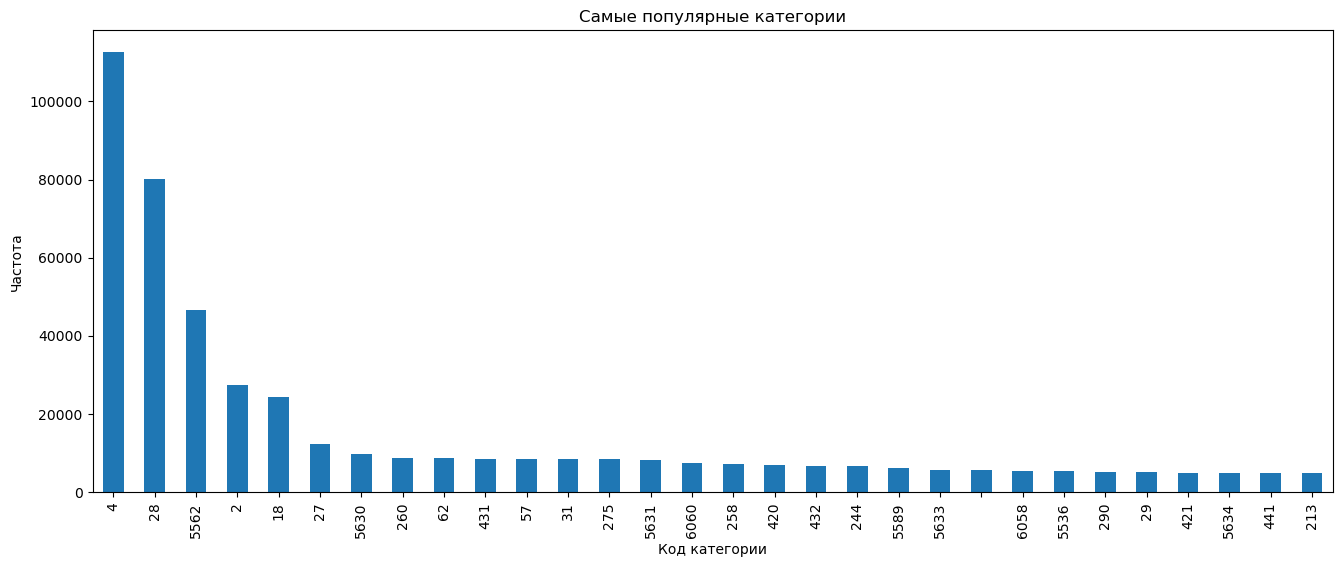

In [73]:
category_popular = category_dummies.sum().sort_values(ascending=False).head(30)

plt.figure(figsize=(16,6))
category_popular.plot(kind='bar')
plt.title('Самые популярные категории')
plt.xlabel('Код категории')
plt.ylabel('Частота')
plt.xticks(rotation=90)
plt.show()

Получили распределение. В 30ку популярнейших попало пропущенное значение.

C:\Users\User\AppData\Local\Temp\ipykernel_2416\1316265154.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=90)
C:\Users\User\AppData\Local\Temp\ipykernel_2416\1316265154.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=90)


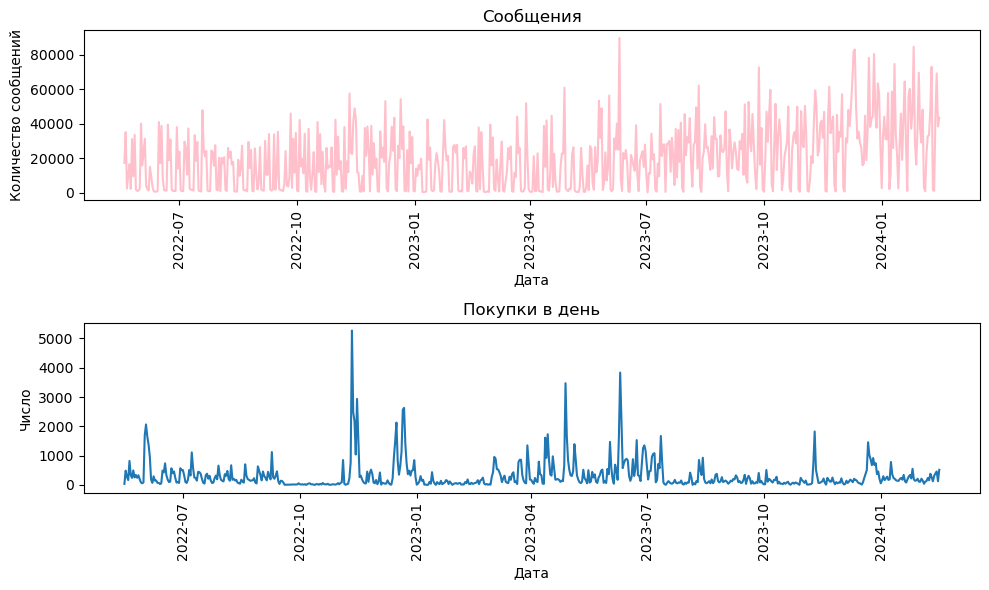

(Timestamp('2022-05-16 00:00:00'), Timestamp('2024-02-16 00:00:00'))

In [75]:
fig, axs = plt.subplots(2, 1, figsize=(10, 6))

# график числа отправленных сообщений по времени
messages['date'].dt.date.value_counts().sort_index().plot(ax=axs[0], color='pink')
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=90)
axs[0].set_xlabel('Дата')
axs[0].set_ylabel('Количество сообщений')
axs[0].set_title('Сообщения')

# распределение покупок по времени
purchases['date'].dt.date.value_counts().sort_index().plot(ax=axs[1])
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=90) 
axs[1].set_xlabel('Дата')
axs[1].set_ylabel('Число')
axs[1].set_title('Покупки в день')

plt.tight_layout()
plt.show()

purchases['date'].min(), purchases['date'].max()

Как видно из сравнения **Число рекламных сообщений - Число покупок**, количество сообщений не всегда влияет на число покупок. Однако есть некоторые совпадения или другие зависимости:
* черная пятница (ноябрь, 2022) самое большое число покупок за все время, пик покупок совпадает с повышением числа рекламных сообщений
* новый год (декабрь, 2022) совпадают
* общее увеличение числа сообщений (июль, 2023 по настоящее время) **не привело** к общему увеличению числа покупок

In [77]:
purchases['day_of_week'] = purchases['date'].dt.dayofweek
purchases['hour'] = purchases['date'].dt.hour

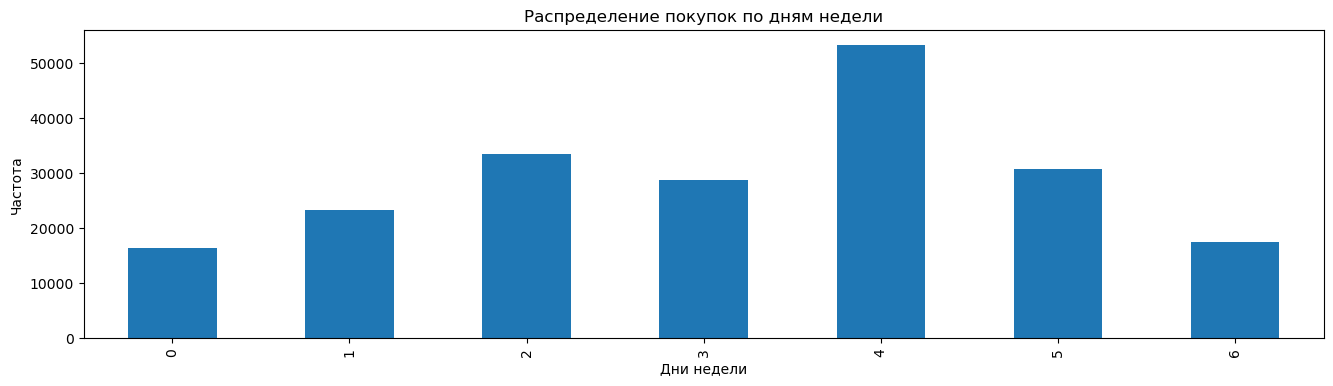

In [78]:
plt.figure(figsize=(16,4))
purchases.groupby('day_of_week')['quantity'].sum().plot(kind='bar')
plt.title('Распределение покупок по дням недели')
plt.xlabel('Дни недели')
plt.ylabel('Частота')
plt.show()
#purchases.groupby('hour')['quantity'].sum().plot(kind='bar')

Пятница самый насыщенный покупками день. 

Понедельник и воскресенье - самые непопулярные дни для совершения покупок.

#### quantity

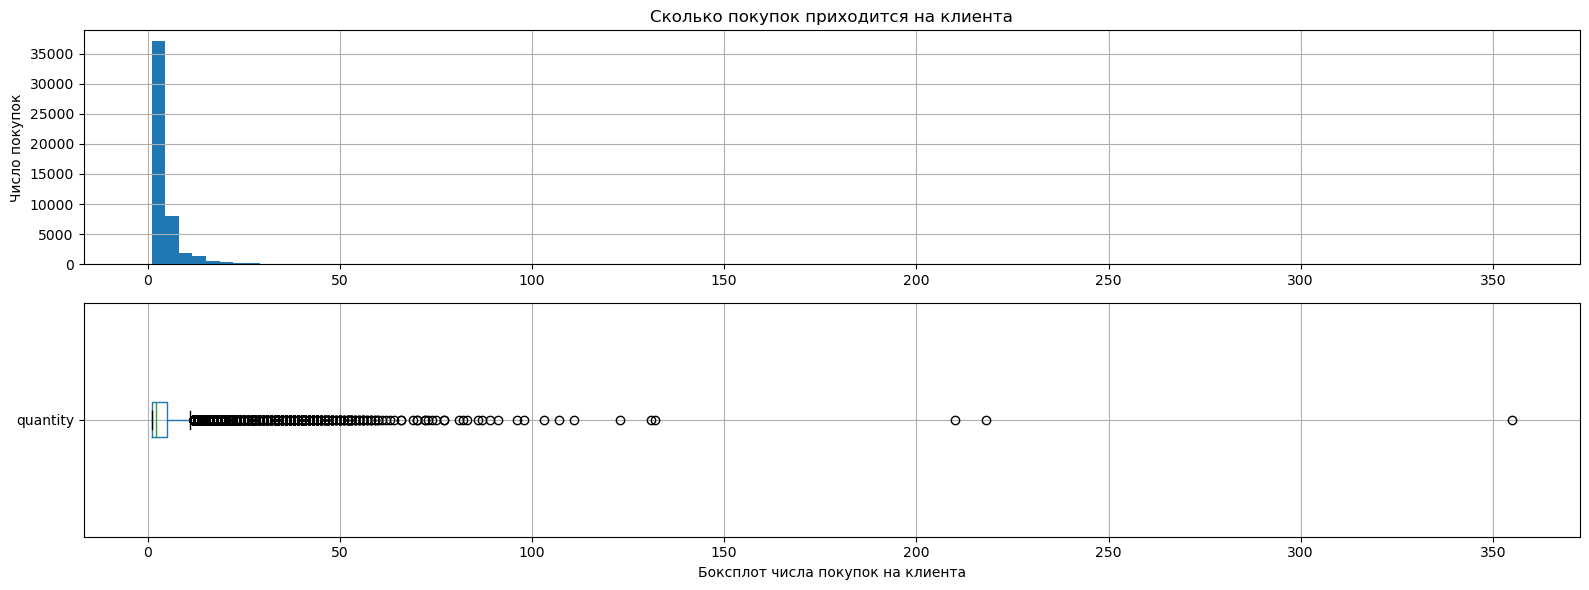

In [81]:
fig, axs = plt.subplots(2, 1, figsize=(16, 6))

purchases.groupby('client_id')['quantity'].sum().hist(bins=100, ax=axs[0])
axs[0].set_title('Сколько покупок приходится на клиента')
axs[0].set_ylabel('Число покупок')

purchases_by_client = purchases.groupby('client_id')['quantity'].sum().reset_index()
purchases_by_client.boxplot(column="quantity", ax=axs[1], vert=False)
axs[1].set_xlabel('Боксплот числа покупок на клиента')

plt.tight_layout()
plt.show()

In [82]:
q1 = purchases['quantity'].quantile(0.25)
q3 = purchases['quantity'].quantile(0.75)

iqr = q3 - q1
#границы выбросов
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

purchases[(purchases['quantity'] < lower_bound) | (purchases['quantity'] > upper_bound)].count()

client_id       885
quantity        885
price           885
category_ids    885
date            885
message_id      885
day_of_week     885
hour            885
dtype: int64

In [83]:
purchases = purchases[(purchases['quantity'] >= lower_bound) & (purchases['quantity'] <= upper_bound)]

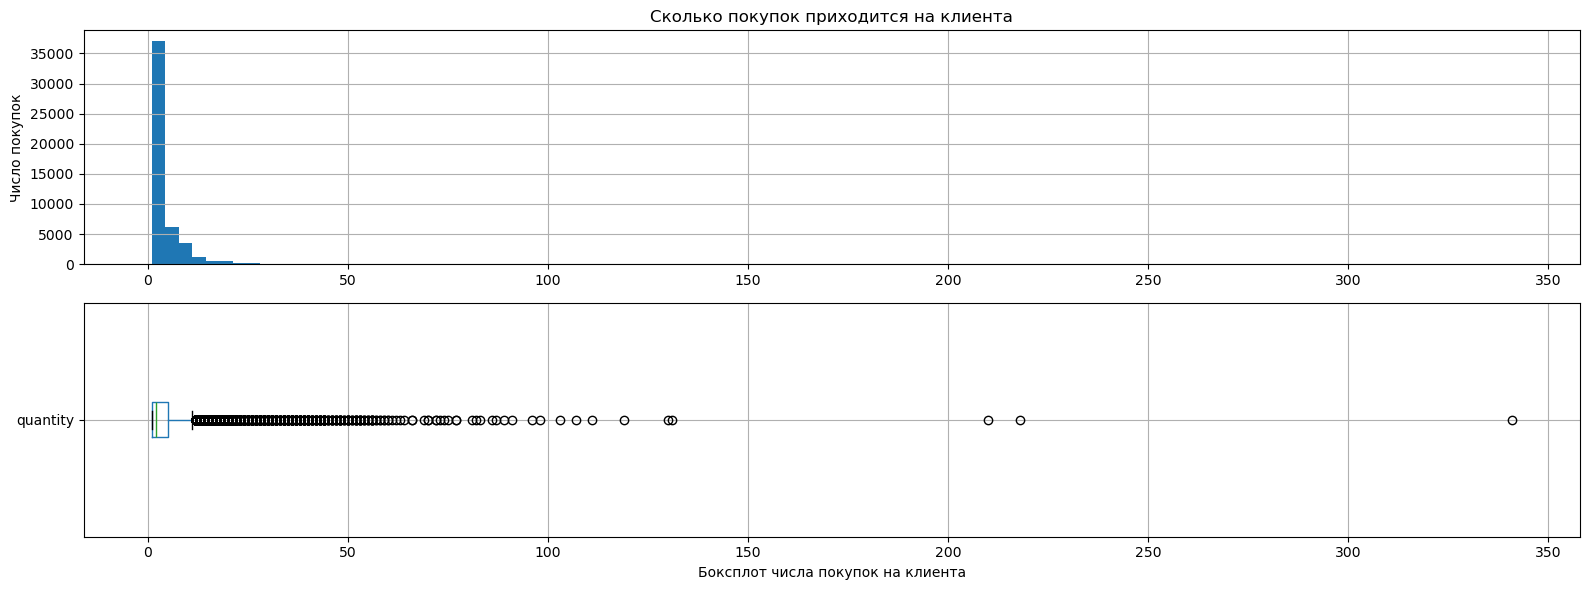

In [84]:
fig, axs = plt.subplots(2, 1, figsize=(16, 6))

purchases.groupby('client_id')['quantity'].sum().hist(bins=100, ax=axs[0])
axs[0].set_title('Сколько покупок приходится на клиента')
axs[0].set_ylabel('Число покупок')

purchases_by_client = purchases.groupby('client_id')['quantity'].sum().reset_index()
purchases_by_client.boxplot(column="quantity", ax=axs[1], vert=False)
axs[1].set_xlabel('Боксплот числа покупок на клиента')

plt.tight_layout()
plt.show()

<Axes: >

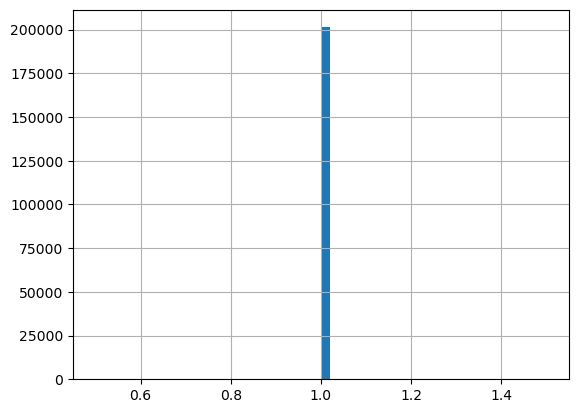

In [85]:
purchases['quantity'].hist(bins=50)

In [86]:
purchases[purchases['quantity'] > 1]

,client_id,quantity,price,category_ids,date,message_id,day_of_week,hour


Каждая покупка в датасете purchases всегда несет 1 единицу quantity. 

#### price

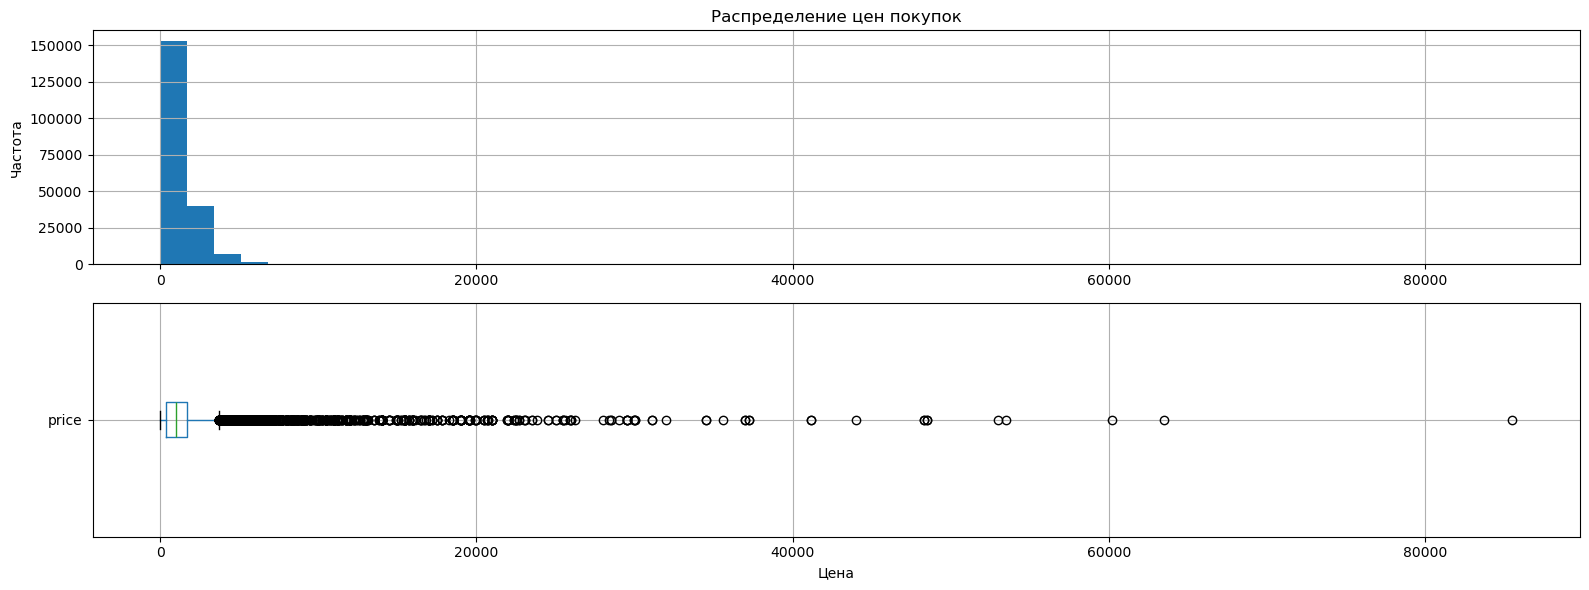

In [89]:
fig, axs = plt.subplots(2, 1, figsize=(16, 6))

purchases['price'].hist(bins=50, ax=axs[0])
axs[0].set_title('Распределение цен покупок')
axs[0].set_ylabel('Частота')

# boxplot
purchases.boxplot(column="price", ax=axs[1], vert=False)
axs[1].set_xlabel('Цена')

plt.tight_layout()
plt.show()

In [90]:
q1 = purchases['price'].quantile(0.25)
q3 = purchases['price'].quantile(0.75)

#purchases[(purchases['Price'] < q1)|(purchases['Price'] > q3)].count()

iqr = q3 - q1
#границы выбросов
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

purchases[(purchases['price'] < lower_bound) | (purchases['price'] > upper_bound)].count()

client_id       6556
quantity        6556
price           6556
category_ids    6556
date            6556
message_id      6556
day_of_week     6556
hour            6556
dtype: int64

Удаляем выбросы покупок с ценами, выходящими за 99% доверительный интервал

In [92]:
purchases = purchases[(purchases['price'] >= lower_bound) & (purchases['price'] <= upper_bound)]

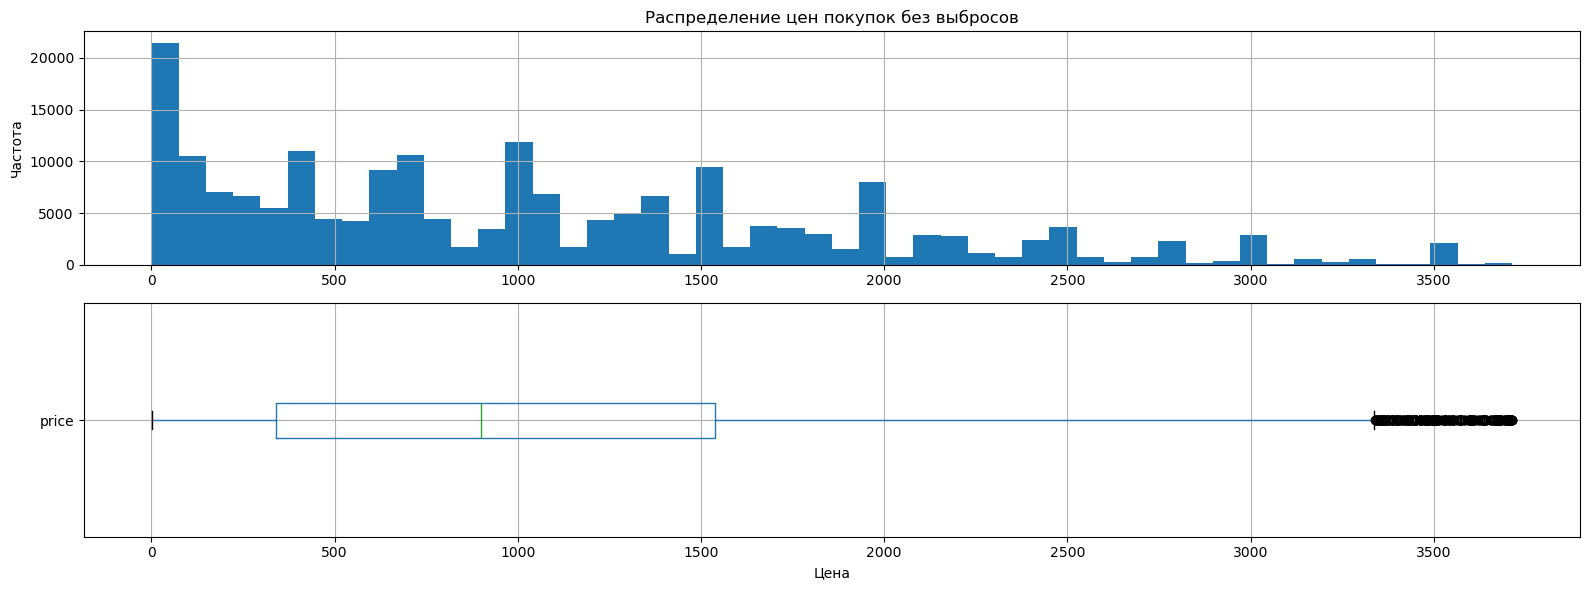

In [93]:
fig, axs = plt.subplots(2, 1, figsize=(16, 6))

purchases['price'].hist(bins=50, ax=axs[0])
axs[0].set_title('Распределение цен покупок без выбросов')
axs[0].set_ylabel('Частота')

purchases.boxplot(column="price", ax=axs[1], vert=False)
axs[1].set_xlabel('Цена')

# Настройка отображения
plt.tight_layout()
plt.show()

На первом месте Цены около 100р. Далее частота цен спускается аж до 4000р. Начиная с 1000р на каждой отсечке по 500р наблюдаем всплески популярности цен, наиболее понятных покупателю масштабов: 1000р, 1500р, 2000р и тд.

### messages

In [96]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype         
---  ------            -----         
 0   bulk_campaign_id  int64         
 1   client_id         int64         
 2   message_id        object        
 3   event             object        
 4   channel           object        
 5   date              datetime64[ns]
 6   created_at        datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(3)
memory usage: 680.4+ MB


In [97]:
messages['event'].unique()

array(['open', 'click', 'purchase', 'send', 'unsubscribe', 'hbq_spam',
       'hard_bounce', 'subscribe', 'soft_bounce', 'complain', 'close'],
      dtype=object)

In [98]:
messages['event'].value_counts(ascending=False)

event
send           9058196
open           3085820
click           496339
purchase         64679
hard_bounce      19903
soft_bounce      10583
unsubscribe       2841
hbq_spam           823
complain           528
subscribe           85
close                1
Name: count, dtype: int64

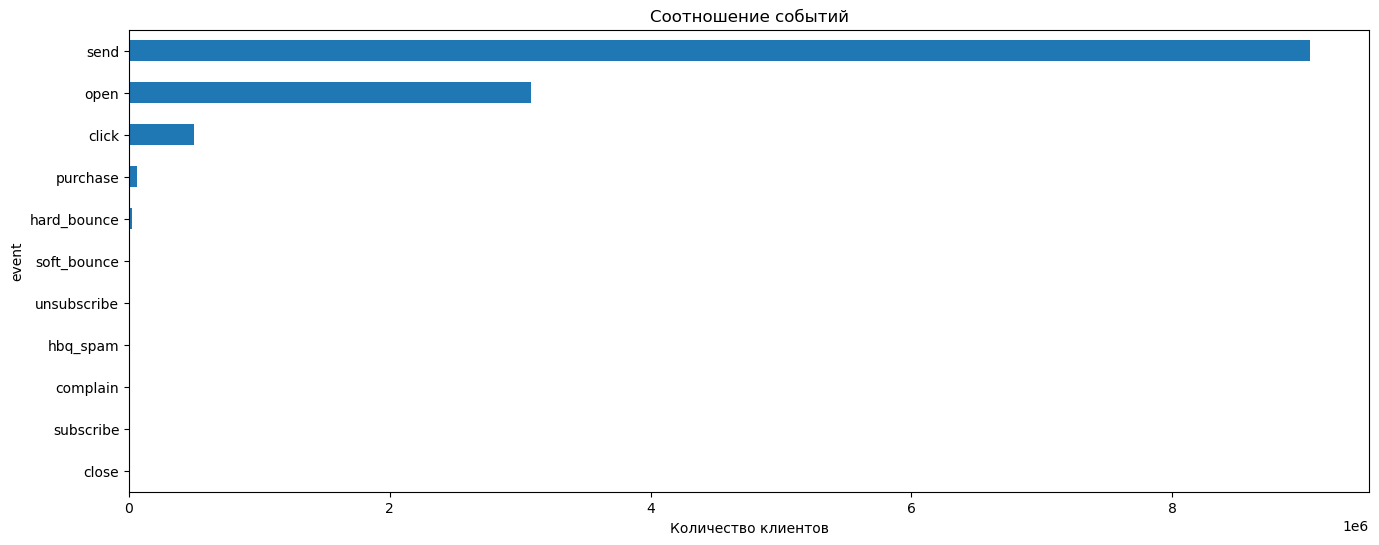

In [99]:
messages['event'].value_counts(ascending=True).plot.barh(figsize = (16, 6))
plt.title('Соотношение событий')
plt.xlabel('Количество клиентов')
plt.show()

Количество сообщений purchase - на 4м месте. Однако, по масштабу общего числа отправленных сообщений их число несравнимо мало.

In [101]:
messages['channel'].unique()

array(['email', 'mobile_push'], dtype=object)

In [102]:
messages['client_id'].nunique()

53329

In [103]:
messages['message_id'].nunique()

9061667

In [104]:
messages['bulk_campaign_id'].nunique()

2709

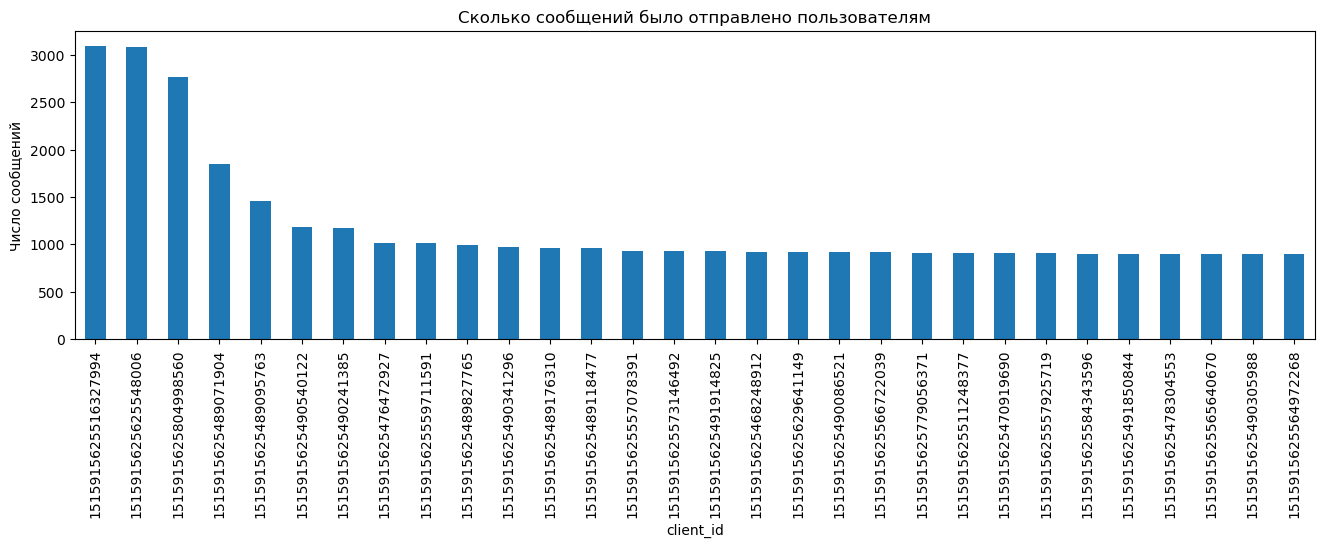

In [105]:
plt.figure(figsize=(16,4))
messages.groupby('client_id')['message_id'].count().sort_values(ascending=False).head(30).plot(kind='bar')
plt.title('Сколько сообщений было отправлено пользователям')
plt.xlabel('client_id')
plt.ylabel('Число сообщений')
plt.show()

Примечательно, что есть 5ка сообщений, которые были отправлены большее число раз, чем все остальные 50 тысяч сообщений.

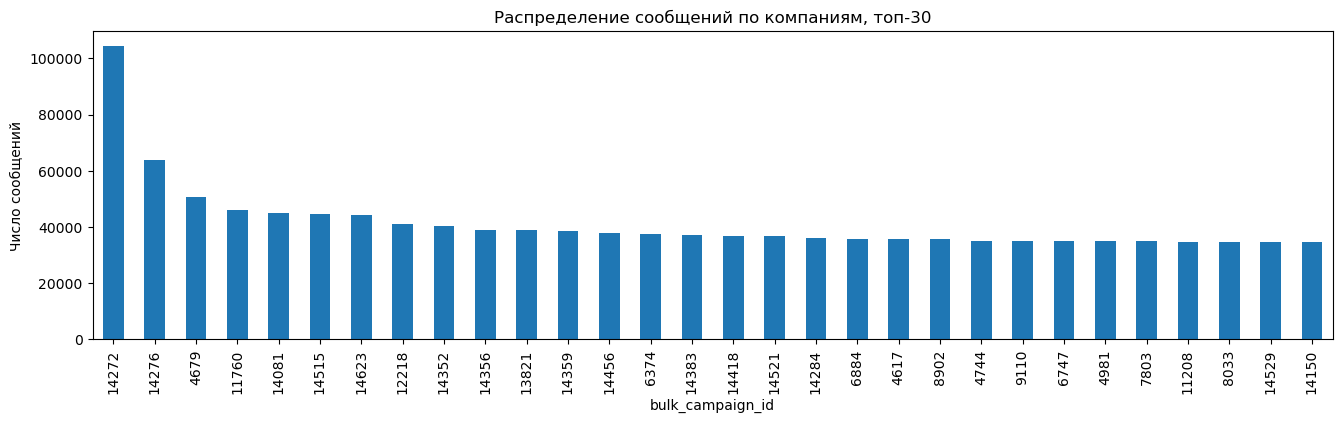

In [107]:
plt.figure(figsize=(16,4))
messages.groupby('bulk_campaign_id')['message_id'].count().sort_values(ascending=False).head(30).plot(kind='bar')
plt.title('Распределение сообщений по компаниям, топ-30')
plt.xlabel('bulk_campaign_id')
plt.ylabel('Число сообщений')
plt.show()

In [108]:
messages['day_of_week'] = messages['created_at'].dt.dayofweek
messages['hour'] = messages['created_at'].dt.hour

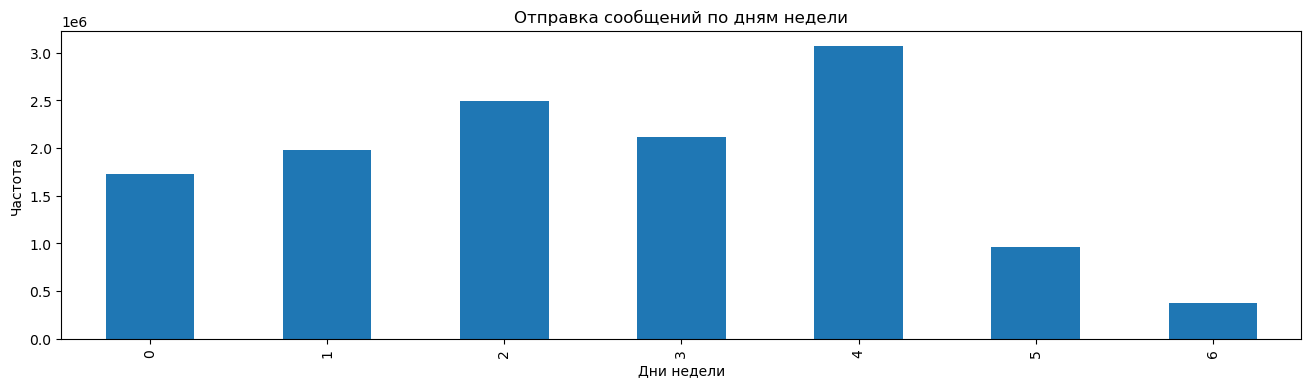

In [109]:
plt.figure(figsize=(16,4))
messages.groupby('day_of_week')['message_id'].count().plot(kind='bar')
plt.title('Отправка сообщений по дням недели')
plt.xlabel('Дни недели')
plt.ylabel('Частота')
plt.show()

Совпадает день наибольшего числа отправленных сообщений и день наибольшего числа покупок.

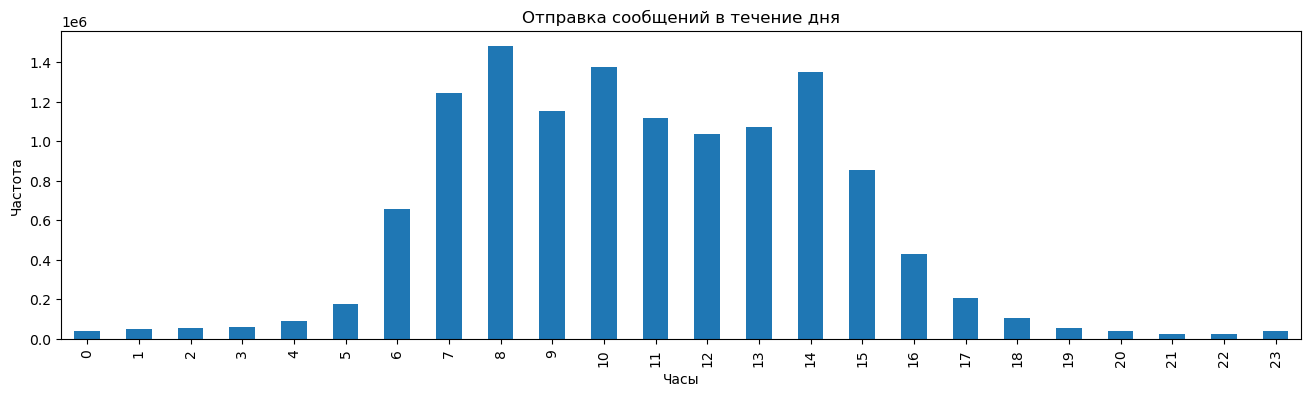

In [111]:
plt.figure(figsize=(16,4))
messages.groupby('hour')['message_id'].count().plot(kind='bar')
plt.title('Отправка сообщений в течение дня')
plt.xlabel('Часы')
plt.ylabel('Частота')
plt.show()

### target

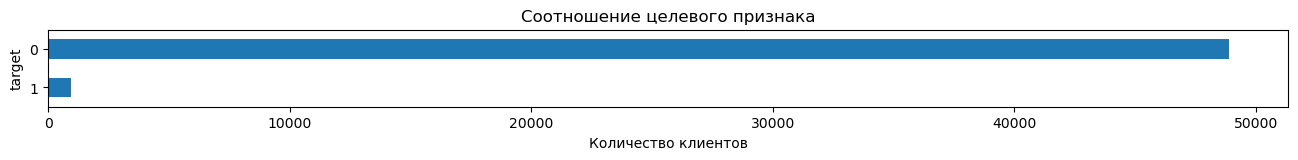

In [113]:
target
target['target'].value_counts(ascending=True).plot.barh(figsize = (16, 1))
plt.title('Соотношение целевого признака')
plt.xlabel("Количество клиентов")
plt.show()

Сильный диспбаланс классов. 

### event

In [116]:
event.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131072 entries, 0 to 131071
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   date                 131072 non-null  datetime64[ns]
 1   bulk_campaign_id     131072 non-null  int64         
 2   count_click          131072 non-null  int64         
 3   count_complain       131072 non-null  int64         
 4   count_hard_bounce    131072 non-null  int64         
 5   count_open           131072 non-null  int64         
 6   count_purchase       131072 non-null  int64         
 7   count_send           131072 non-null  int64         
 8   count_soft_bounce    131072 non-null  int64         
 9   count_subscribe      131072 non-null  int64         
 10  count_unsubscribe    131072 non-null  int64         
 11  nunique_click        131072 non-null  int64         
 12  nunique_complain     131072 non-null  int64         
 13  nunique_hard_b

In [117]:
event.head(3)

,date,bulk_campaign_id,count_click,count_complain,count_hard_bounce,count_open,count_purchase,count_send,count_soft_bounce,count_subscribe,...,nunique_open,nunique_purchase,nunique_send,nunique_soft_bounce,nunique_subscribe,nunique_unsubscribe,count_hbq_spam,nunique_hbq_spam,count_close,nunique_close
0,2022-05-19,563,0,0,0,4,0,0,0,0,...,4,0,0,0,0,0,0,0,0,0
1,2022-05-19,577,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,2022-05-19,622,0,0,0,2,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0


### channel

In [119]:
channel.head(3)

,date,bulk_campaign_id,count_click_email,count_click_mobile_push,count_open_email,count_open_mobile_push,count_purchase_email,count_purchase_mobile_push,count_soft_bounce_email,count_subscribe_email,...,count_send_email,nunique_hard_bounce_email,nunique_hbq_spam_email,nunique_send_email,count_soft_bounce_mobile_push,nunique_soft_bounce_mobile_push,count_complain_email,nunique_complain_email,count_close_mobile_push,nunique_close_mobile_push
0,2022-05-19,563,0,0,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2022-05-19,577,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2022-05-19,622,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Создание признаков

In [121]:
target.shape

(49849, 2)

#### total_messages

In [123]:
messages['event'].unique()

array(['open', 'click', 'purchase', 'send', 'unsubscribe', 'hbq_spam',
       'hard_bounce', 'subscribe', 'soft_bounce', 'complain', 'close'],
      dtype=object)

In [124]:
#messages[messages['client_id']==1515915626010266132].head(50)

In [125]:
messages_per_client = messages.groupby('client_id')['message_id'].count().reset_index(name='messages_sent')
df = target.merge(messages_per_client, on='client_id', how='left')

df

,client_id,target,messages_sent
0,1515915625468060902,0,177.0
1,1515915625468061003,1,166.0
2,1515915625468061099,0,276.0
3,1515915625468061100,0,434.0
4,1515915625468061170,0,293.0
...,...,...,...
49844,1515915626010261344,0,3.0
49845,1515915626010266132,0,NaN
49846,1515915626010439406,0,NaN
49847,1515915626010443527,0,NaN


In [126]:
df['messages_sent'].isna().sum()

7867

In [127]:
df['messages_sent'] = df['messages_sent'].fillna(df['messages_sent'].median())

df

,client_id,target,messages_sent
0,1515915625468060902,0,177.0
1,1515915625468061003,1,166.0
2,1515915625468061099,0,276.0
3,1515915625468061100,0,434.0
4,1515915625468061170,0,293.0
...,...,...,...
49844,1515915626010261344,0,3.0
49845,1515915626010266132,0,233.0
49846,1515915626010439406,0,233.0
49847,1515915626010443527,0,233.0


#### quantity_total

In [129]:
quantity_total = purchases.groupby('client_id')['quantity'].sum().rename('quantity_total').reset_index()
df = df.merge(quantity_total, on='client_id', how='left')

df

,client_id,target,messages_sent,quantity_total
0,1515915625468060902,0,177.0,7.0
1,1515915625468061003,1,166.0,7.0
2,1515915625468061099,0,276.0,1.0
3,1515915625468061100,0,434.0,2.0
4,1515915625468061170,0,293.0,19.0
...,...,...,...,...
49844,1515915626010261344,0,3.0,6.0
49845,1515915626010266132,0,233.0,2.0
49846,1515915626010439406,0,233.0,2.0
49847,1515915626010443527,0,233.0,1.0


In [130]:
df['quantity_total'] = df['quantity_total'].fillna(df['quantity_total'].median())

In [131]:
#df[(df['quantity_total'].isna())&(df['messages_sent'].isna())]['client_id'].count()

In [132]:
#purchases[purchases['client_id'] == 1515915625489489133]

In [133]:
#messages[messages['client_id'] == 1515915625489489133]

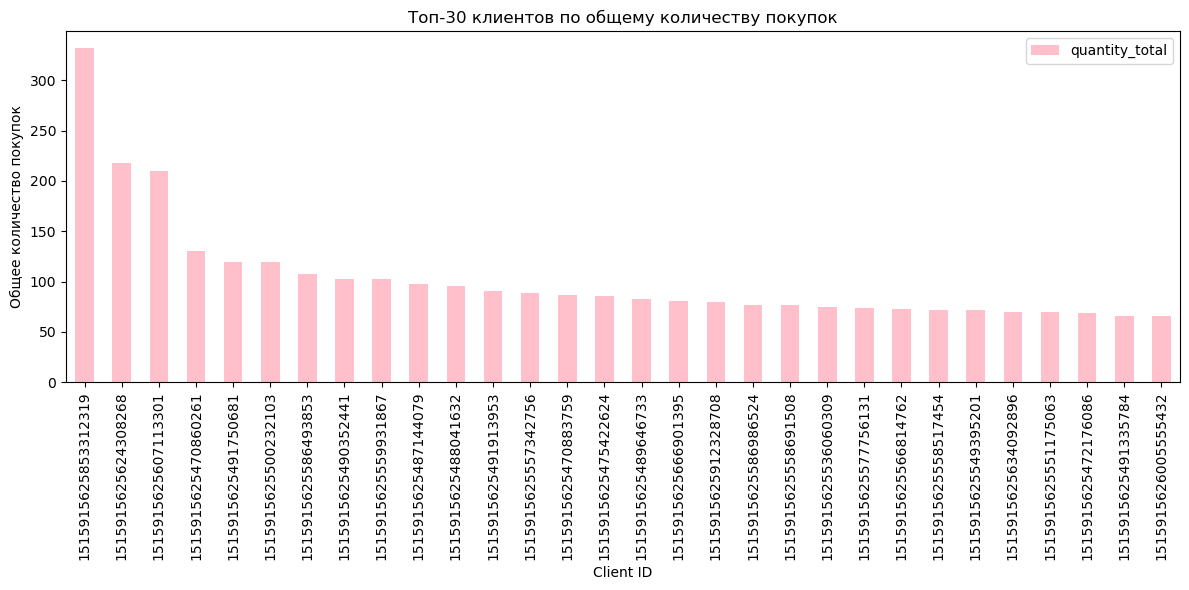

In [134]:
df.sort_values(by='quantity_total', ascending=False).head(30) \
[['client_id', 'quantity_total']].plot(x='client_id', 
                                       y='quantity_total', 
                                       kind='bar', 
                                       figsize=(12, 6), 
                                       color='pink')

plt.title('Топ-30 клиентов по общему количеству покупок')
plt.xlabel('Client ID')
plt.ylabel('Общее количество покупок')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

#### total_spent

In [136]:
total_spent = purchases.groupby('client_id')['price'].sum().rename('total_spent').reset_index()
df = df.merge(total_spent, on='client_id', how='left')
df

,client_id,target,messages_sent,quantity_total,total_spent
0,1515915625468060902,0,177.0,7.0,6993.0
1,1515915625468061003,1,166.0,7.0,16235.0
2,1515915625468061099,0,276.0,1.0,299.0
3,1515915625468061100,0,434.0,2.0,2098.0
4,1515915625468061170,0,293.0,19.0,33601.0
...,...,...,...,...,...
49844,1515915626010261344,0,3.0,6.0,8994.0
49845,1515915626010266132,0,233.0,2.0,1818.0
49846,1515915626010439406,0,233.0,2.0,198.0
49847,1515915626010443527,0,233.0,1.0,1999.0


In [137]:
df['total_spent'].isna().sum()

1859

In [138]:
df['total_spent'] = df['total_spent'].fillna(df['total_spent'].median())

df['total_spent'].isna().sum()

0

In [139]:
#purchases[purchases['client_id'] == 1515915625468060902]

#### avg_price

In [141]:
# этот признак совсем незначительно поднял метрику на 0.003
avg_price = purchases.groupby('client_id')['price'].mean().rename('avg_price').reset_index()
df = df.merge(avg_price, on='client_id', how='left')

df

,client_id,target,messages_sent,quantity_total,total_spent,avg_price
0,1515915625468060902,0,177.0,7.0,6993.0,999.000000
1,1515915625468061003,1,166.0,7.0,16235.0,2319.285714
2,1515915625468061099,0,276.0,1.0,299.0,299.000000
3,1515915625468061100,0,434.0,2.0,2098.0,1049.000000
4,1515915625468061170,0,293.0,19.0,33601.0,1768.473684
...,...,...,...,...,...,...
49844,1515915626010261344,0,3.0,6.0,8994.0,1499.000000
49845,1515915626010266132,0,233.0,2.0,1818.0,909.000000
49846,1515915626010439406,0,233.0,2.0,198.0,99.000000
49847,1515915626010443527,0,233.0,1.0,1999.0,1999.000000


In [142]:
df['avg_price'].isna().sum()

1859

In [143]:
df['avg_price'] = df['avg_price'].fillna(df['avg_price'].median())

df['avg_price'].isna().sum()

0

#### avg_days_between_purchases

Так как наш целевой признак основан на покупке за определенный период в будущем, то мы просто обязаны добавить признак, характеризующий частоту покупок.

In [146]:
purchases_sorted = purchases[['client_id','date']].sort_values(['client_id','date'])
purchases_sorted

,client_id,date
3695,1515915625468060902,2022-05-27
3696,1515915625468060902,2022-05-27
3697,1515915625468060902,2022-05-27
3698,1515915625468060902,2022-05-27
3699,1515915625468060902,2022-05-27
...,...,...
201564,1515915626010266132,2024-02-14
202204,1515915626010439406,2024-02-16
202205,1515915626010439406,2024-02-16
202206,1515915626010443527,2024-02-16


In [147]:
purchases_sorted['days_between_purchases'] = purchases_sorted.groupby('client_id')['date'].diff().dt.days
purchases_sorted.head(10)

,client_id,date,days_between_purchases
3695,1515915625468060902,2022-05-27,NaN
3696,1515915625468060902,2022-05-27,0.0
3697,1515915625468060902,2022-05-27,0.0
3698,1515915625468060902,2022-05-27,0.0
3699,1515915625468060902,2022-05-27,0.0
3700,1515915625468060902,2022-05-27,0.0
3701,1515915625468060902,2022-05-27,0.0
81792,1515915625468061003,2023-01-04,NaN
81793,1515915625468061003,2023-01-04,0.0
81794,1515915625468061003,2023-01-04,0.0


In [148]:
average_days_between_purchases = purchases_sorted.groupby('client_id')['days_between_purchases'] \
                                                 .mean().reset_index(name='avg_days_between_purchases')

average_days_between_purchases['avg_days_between_purchases'] = average_days_between_purchases['avg_days_between_purchases'] \
                                                                                              .fillna(0)
average_days_between_purchases

,client_id,avg_days_between_purchases
0,1515915625468060902,0.000000
1,1515915625468061003,0.000000
2,1515915625468061099,0.000000
3,1515915625468061100,0.000000
4,1515915625468061170,4.611111
...,...,...
47985,1515915626010261344,0.000000
47986,1515915626010266132,0.000000
47987,1515915626010439406,0.000000
47988,1515915626010443527,0.000000


In [149]:
df = df.merge(average_days_between_purchases, on='client_id', how='left')

df

,client_id,target,messages_sent,quantity_total,total_spent,avg_price,avg_days_between_purchases
0,1515915625468060902,0,177.0,7.0,6993.0,999.000000,0.000000
1,1515915625468061003,1,166.0,7.0,16235.0,2319.285714,0.000000
2,1515915625468061099,0,276.0,1.0,299.0,299.000000,0.000000
3,1515915625468061100,0,434.0,2.0,2098.0,1049.000000,0.000000
4,1515915625468061170,0,293.0,19.0,33601.0,1768.473684,4.611111
...,...,...,...,...,...,...,...
49844,1515915626010261344,0,3.0,6.0,8994.0,1499.000000,0.000000
49845,1515915626010266132,0,233.0,2.0,1818.0,909.000000,0.000000
49846,1515915626010439406,0,233.0,2.0,198.0,99.000000,0.000000
49847,1515915626010443527,0,233.0,1.0,1999.0,1999.000000,0.000000


In [150]:
df['avg_days_between_purchases'].isna().sum()

1859

In [151]:
df['avg_days_between_purchases'] = df['avg_days_between_purchases'].fillna(df['avg_days_between_purchases'].median())

#### days_since_last_purchase

In [153]:
purchases['date'].max()

Timestamp('2024-02-16 00:00:00')

In [154]:
#purchases_sorted.head(10)

In [155]:
# дата последней покупки клиента
last_purchase_date = purchases.groupby('client_id')['date'].max().rename('last_purchase_date')
df = df.merge(last_purchase_date, on='client_id', how='left')

df

,client_id,target,messages_sent,quantity_total,total_spent,avg_price,avg_days_between_purchases,last_purchase_date
0,1515915625468060902,0,177.0,7.0,6993.0,999.000000,0.000000,2022-05-27
1,1515915625468061003,1,166.0,7.0,16235.0,2319.285714,0.000000,2023-01-04
2,1515915625468061099,0,276.0,1.0,299.0,299.000000,0.000000,2022-05-17
3,1515915625468061100,0,434.0,2.0,2098.0,1049.000000,0.000000,2024-02-10
4,1515915625468061170,0,293.0,19.0,33601.0,1768.473684,4.611111,2023-06-17
...,...,...,...,...,...,...,...,...
49844,1515915626010261344,0,3.0,6.0,8994.0,1499.000000,0.000000,2024-02-16
49845,1515915626010266132,0,233.0,2.0,1818.0,909.000000,0.000000,2024-02-14
49846,1515915626010439406,0,233.0,2.0,198.0,99.000000,0.000000,2024-02-16
49847,1515915626010443527,0,233.0,1.0,1999.0,1999.000000,0.000000,2024-02-16


In [156]:
# количество дней с полученной даты последней покупки
df['days_since_last_purchase'] = (purchases['date'].max() - df['last_purchase_date']).dt.days

df

,client_id,target,messages_sent,quantity_total,total_spent,avg_price,avg_days_between_purchases,last_purchase_date,days_since_last_purchase
0,1515915625468060902,0,177.0,7.0,6993.0,999.000000,0.000000,2022-05-27,630.0
1,1515915625468061003,1,166.0,7.0,16235.0,2319.285714,0.000000,2023-01-04,408.0
2,1515915625468061099,0,276.0,1.0,299.0,299.000000,0.000000,2022-05-17,640.0
3,1515915625468061100,0,434.0,2.0,2098.0,1049.000000,0.000000,2024-02-10,6.0
4,1515915625468061170,0,293.0,19.0,33601.0,1768.473684,4.611111,2023-06-17,244.0
...,...,...,...,...,...,...,...,...,...
49844,1515915626010261344,0,3.0,6.0,8994.0,1499.000000,0.000000,2024-02-16,0.0
49845,1515915626010266132,0,233.0,2.0,1818.0,909.000000,0.000000,2024-02-14,2.0
49846,1515915626010439406,0,233.0,2.0,198.0,99.000000,0.000000,2024-02-16,0.0
49847,1515915626010443527,0,233.0,1.0,1999.0,1999.000000,0.000000,2024-02-16,0.0


In [157]:
df = df.drop('last_purchase_date', axis=1)

In [158]:
df['days_since_last_purchase'] = df['days_since_last_purchase'].fillna(df['days_since_last_purchase'].median())

df['days_since_last_purchase'].isna().sum()

0

#### fav_cat 

In [160]:
purchases.head(3)

,client_id,quantity,price,category_ids,date,message_id,day_of_week,hour
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,0,0
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,0,0
5,1515915625471640575,1,3499.0,"['2', '18', '258', '441']",2022-05-16,1515915625471640575-4301-627b661b67ac3,0,0


In [161]:
#purchases['category_ids'].unique()

In [162]:
# разбиваем столбец category_ids на отдельные категории
purchases['category_list'] = purchases['category_ids'].str.strip("[]").str.replace("'", "").str.split(", ")
purchases

,client_id,quantity,price,category_ids,date,message_id,day_of_week,hour,category_list
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,0,0,"[4, 28, 57, 431]"
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,0,0,"[4, 28, 57, 431]"
5,1515915625471640575,1,3499.0,"['2', '18', '258', '441']",2022-05-16,1515915625471640575-4301-627b661b67ac3,0,0,"[2, 18, 258, 441]"
6,1515915625490211585,1,1699.0,"['2', '18', '341', '1311']",2022-05-16,1515915625490211585-4301-627b661843283,0,0,"[2, 18, 341, 1311]"
7,1515915625490739153,1,1999.0,"['2', '18', '123', '451']",2022-05-16,1515915625490739153-4172-626b943cc789b,0,0,"[2, 18, 123, 451]"
...,...,...,...,...,...,...,...,...,...
202203,1515915626010261344,1,1499.0,"['2', '18', '212', '726']",2024-02-16,1515915626010261344-14648-65cdb6d56c4c8,4,0,"[2, 18, 212, 726]"
202204,1515915626010439406,1,99.0,"['4', '27', '233', '462']",2024-02-16,1515915625776605028-14662-65cf3abfe4f0d,4,0,"[4, 27, 233, 462]"
202205,1515915626010439406,1,99.0,"['4', '27', '233', '462']",2024-02-16,1515915625776605028-14662-65cf3abfe4f0d,4,0,"[4, 27, 233, 462]"
202206,1515915626010443527,1,1999.0,"['2', '18', '274', '446']",2024-02-16,1515915625766077627-14668-65cf5246bd490,4,0,"[2, 18, 274, 446]"


In [163]:
# функция для заполнения списка до 4 элементов
def pad_categories(categories):
    # заполняем недостающие пустым значением, чтобы завести 4 столбца
    while len(categories) < 4:
        categories.append('None')
    return categories[:4]  # Возвращаем только первые 4 элемента

In [164]:
# находим самую часто встречающуюся комбинацию категорий для каждого клиента
fav_categories = purchases.groupby('client_id')['category_list'] \
                          .agg(lambda x: x.mode()[0] if not x.mode().empty else ['None'])

fav_categories

client_id
1515915625468060902      [4, 27, 176, 458]
1515915625468061003      [4, 28, 249, 615]
1515915625468061099      [4, 28, 290, 424]
1515915625468061100    [4, 27, 1828, 5717]
1515915625468061170      [4, 28, 260, 420]
                              ...         
1515915626010261344      [2, 18, 212, 726]
1515915626010266132      [4, 27, 278, 470]
1515915626010439406      [4, 27, 233, 462]
1515915626010443527      [2, 18, 274, 446]
1515915626010443624       [4, 28, 62, 656]
Name: category_list, Length: 47990, dtype: object

In [165]:
# заполняем пустые места с помощью функции
fav_categories_padded = fav_categories.apply(pad_categories)

fav_categories_padded

client_id
1515915625468060902      [4, 27, 176, 458]
1515915625468061003      [4, 28, 249, 615]
1515915625468061099      [4, 28, 290, 424]
1515915625468061100    [4, 27, 1828, 5717]
1515915625468061170      [4, 28, 260, 420]
                              ...         
1515915626010261344      [2, 18, 212, 726]
1515915626010266132      [4, 27, 278, 470]
1515915626010439406      [4, 27, 233, 462]
1515915626010443527      [2, 18, 274, 446]
1515915626010443624       [4, 28, 62, 656]
Name: category_list, Length: 47990, dtype: object

In [166]:
# превращаем эти списки в столбцы
fav_categories_df = pd.DataFrame(fav_categories_padded.tolist(), index=fav_categories.index, 
                                 columns=['fav_cat_01', 'fav_cat_02', 'fav_cat_03', 'fav_cat_04'])

fav_categories_df

,fav_cat_01,fav_cat_02,fav_cat_03,fav_cat_04
client_id,,,,
1515915625468060902,4,27,176,458
1515915625468061003,4,28,249,615
1515915625468061099,4,28,290,424
1515915625468061100,4,27,1828,5717
1515915625468061170,4,28,260,420
...,...,...,...,...
1515915626010261344,2,18,212,726
1515915626010266132,4,27,278,470
1515915626010439406,4,27,233,462


In [167]:
df = df.merge(fav_categories_df, on='client_id', how='left')

for col in ['fav_cat_01', 'fav_cat_02', 'fav_cat_03', 'fav_cat_04']:
    df[col] = df[col].astype('category')

df

,client_id,target,messages_sent,quantity_total,total_spent,avg_price,avg_days_between_purchases,days_since_last_purchase,fav_cat_01,fav_cat_02,fav_cat_03,fav_cat_04
0,1515915625468060902,0,177.0,7.0,6993.0,999.000000,0.000000,630.0,4,27,176,458
1,1515915625468061003,1,166.0,7.0,16235.0,2319.285714,0.000000,408.0,4,28,249,615
2,1515915625468061099,0,276.0,1.0,299.0,299.000000,0.000000,640.0,4,28,290,424
3,1515915625468061100,0,434.0,2.0,2098.0,1049.000000,0.000000,6.0,4,27,1828,5717
4,1515915625468061170,0,293.0,19.0,33601.0,1768.473684,4.611111,244.0,4,28,260,420
...,...,...,...,...,...,...,...,...,...,...,...,...
49844,1515915626010261344,0,3.0,6.0,8994.0,1499.000000,0.000000,0.0,2,18,212,726
49845,1515915626010266132,0,233.0,2.0,1818.0,909.000000,0.000000,2.0,4,27,278,470
49846,1515915626010439406,0,233.0,2.0,198.0,99.000000,0.000000,0.0,4,27,233,462
49847,1515915626010443527,0,233.0,1.0,1999.0,1999.000000,0.000000,0.0,2,18,274,446


In [168]:
#purchases[purchases['client_id']==1515915625468060902]

## Корреляционный анализ

In [170]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   client_id                   49849 non-null  int64   
 1   target                      49849 non-null  int64   
 2   messages_sent               49849 non-null  float64 
 3   quantity_total              49849 non-null  float64 
 4   total_spent                 49849 non-null  float64 
 5   avg_price                   49849 non-null  float64 
 6   avg_days_between_purchases  49849 non-null  float64 
 7   days_since_last_purchase    49849 non-null  float64 
 8   fav_cat_01                  47990 non-null  category
 9   fav_cat_02                  47990 non-null  category
 10  fav_cat_03                  47990 non-null  category
 11  fav_cat_04                  47990 non-null  category
dtypes: category(4), float64(6), int64(2)
memory usage: 3.4 MB


interval columns not set, guessing: ['target', 'messages_sent', 'quantity_total', 'total_spent', 'avg_price', 'avg_days_between_purchases', 'days_since_last_purchase']


<Axes: >

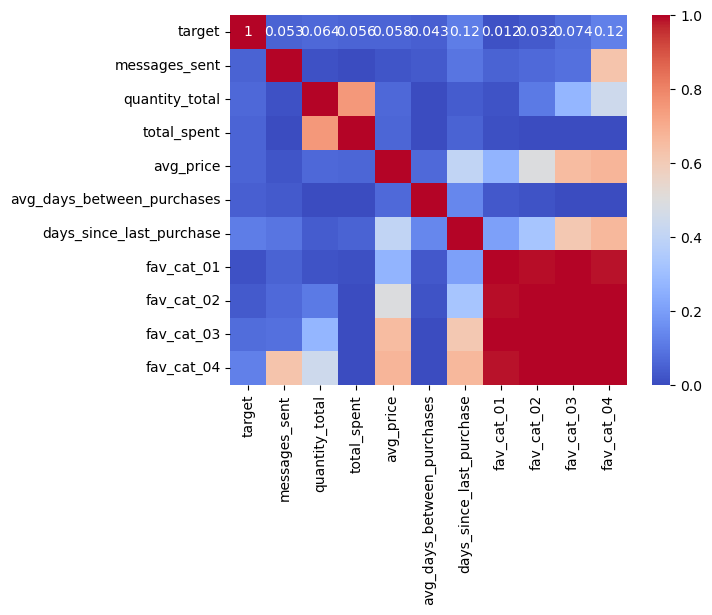

In [171]:
fig, ax = plt.subplots()
sns.heatmap(df.drop(['client_id'], axis=1).phik_matrix(),
            annot=True,
            cmap='coolwarm',
            ax=ax)

Ожидаема была гиперкорреляция 4х категорий. Во избежание переобучения и чтобы облегчить датасет, оставим только первую категорию. 

К сожалению, корреляция всех признаков близка к 0.1 коэффициенту, а чаще сильно ниже. 

## Модель

### Подготовка

In [175]:
# Оптимизация числовых типов данных
def optimize_memory_usage(df: pd.DataFrame, print_size: bool=True) -> pd.DataFrame:
    '''
    Function optimizes memory usage in dataframe
    df: pd.DataFrame - data table
    print_size: bool - display of optimization results
    return pd.DataFrame - amount of optimized memory
    '''
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64'] # Типы, которые будем проверять на оптимизацию
    # Размер занимаемой памяти до оптимизации (в Мб)
    before_size = df.memory_usage().sum() / 1024**2    
    for column in df.columns:
        column_type = df[column].dtypes
        if column_type in numerics:
            column_min = df[column].min()
            column_max = df[column].max()
            if str(column_type).startswith('int'):
                if column_min > np.iinfo(np.int8).min and column_max < np.iinfo(np.int8).max:
                    df[column] = df[column].astype(np.int8)
                elif column_min > np.iinfo(np.int16).min and column_max < np.iinfo(np.int16).max:
                    df[column] = df[column].astype(np.int16)
                elif column_min > np.iinfo(np.int32).min and column_max < np.iinfo(np.int32).max:
                    df[column] = df[column].astype(np.int32)
                elif column_min > np.iinfo(np.int64).min and column_max < np.iinfo(np.int64).max:
                    df[column] = df[column].astype(np.int64)  
            else:
                if column_min > np.finfo(np.float32).min and column_max < np.finfo(np.float32).max:
                    df[column] = df[column].astype(np.float32)
                else:
                    df[column] = df[column].astype(np.float64)    
    # Размер занимаемой памяти после оптимизации (в Мб)
    after_size = df.memory_usage().sum() / 1024**2
    if print_size: print('Размер использования памяти: до {:5.2f} Mb - после {:5.2f} Mb ({:.1f}%)'
                         .format(before_size, after_size, 100 * (before_size - after_size) / before_size))
    return df

In [176]:
df = optimize_memory_usage(df)

Размер использования памяти: до  3.36 Mb - после  1.89 Mb (43.8%)


In [177]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   client_id                   49849 non-null  int64   
 1   target                      49849 non-null  int8    
 2   messages_sent               49849 non-null  float32 
 3   quantity_total              49849 non-null  float32 
 4   total_spent                 49849 non-null  float32 
 5   avg_price                   49849 non-null  float32 
 6   avg_days_between_purchases  49849 non-null  float32 
 7   days_since_last_purchase    49849 non-null  float32 
 8   fav_cat_01                  47990 non-null  category
 9   fav_cat_02                  47990 non-null  category
 10  fav_cat_03                  47990 non-null  category
 11  fav_cat_04                  47990 non-null  category
dtypes: category(4), float32(6), int64(1), int8(1)
memory usage: 1.9 MB


In [178]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [179]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['client_id','target'], axis=1),
    df['target'],
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE,
    stratify=df['target'])

In [180]:
display(X_train.shape)
display(y_train.shape)

display(X_test.shape)
display(y_test.shape)

(37386, 10)

(37386,)

(12463, 10)

(12463,)

### Пайплайн

In [182]:
cat = ['fav_cat_01']
num = ['quantity_total', 
       'messages_sent',
       'total_spent',
       'avg_days_between_purchases',
       'days_since_last_purchase',
       'avg_price']
#ord_columns = ['']

In [183]:
# препроцессоры для линейной модели и бустингов
preprocessor_lr = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat)
    ]
)

preprocessor_boost = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', num),
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), cat)
    ]
)

In [184]:
models = {
    'LogisticRegression': (LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', penalty='l1'), 
                           preprocessor_lr),
    
    'DecisionTreeClassifier': (DecisionTreeClassifier(random_state=RANDOM_STATE), 
                               preprocessor_lr),
    
    'SVC': (SVC(probability=True), 
            preprocessor_lr),
    
    'KNeighborsClassifier': (KNeighborsClassifier(), 
                             preprocessor_lr),
    
    'CatBoostClassifier': (CatBoostClassifier(verbose=0, random_state=RANDOM_STATE), 
                           preprocessor_boost),
    
    'LGBMClassifier': (LGBMClassifier(random_state=RANDOM_STATE), 
                       preprocessor_boost)
}

In [185]:
pipe_final = Pipeline([
    ('preprocessor', preprocessor_lr),  
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE)) 
])

In [186]:
param_dist = [
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', penalty='l1')],
        'models__C': range(1, 5),
        'preprocessor': [preprocessor_lr]
    },
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5),
        'preprocessor': [preprocessor_lr]
    },
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor': [preprocessor_lr]
    },
    {
        'models': [SVC(probability=True)],
        'models__kernel': ['linear', 'rbf'],
        'preprocessor': [preprocessor_lr]
    },
    {
        'models': [CatBoostClassifier(verbose=0, random_state=RANDOM_STATE)],
        'models__iterations': [50],
        'models__depth': [3, 5],
        'preprocessor': [preprocessor_boost]
    },
    {
        'models': [XGBClassifier(random_state=RANDOM_STATE)],
        'models__n_estimators': [50],
        'models__max_depth': [3, 5],
        'preprocessor': [preprocessor_boost]
    },
    {
        'models': [LGBMClassifier(random_state=RANDOM_STATE)],
        'models__n_estimators': [50],
        'models__max_depth': [3, 5],
        'preprocessor': [preprocessor_boost]
    }
]

### Поиск

In [188]:
joblib.parallel_backend('threading')

In [189]:
# RandomizedSearch использовали для теста новых признаков
'''
search = RandomizedSearchCV(
    pipe_final,
    param_distributions=param_dist,
    n_iter=5,  # позже увеличить
    cv=3,
    verbose=10,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
'''

"\nsearch = RandomizedSearchCV(\n    pipe_final,\n    param_distributions=param_dist,\n    n_iter=5,  # позже увеличить\n    cv=3,\n    verbose=10,\n    scoring='roc_auc',\n    random_state=RANDOM_STATE,\n    n_jobs=-1\n)\n"

In [190]:
# для улучшения метрики переберем гиперпараметры на GridSearch
search = GridSearchCV(
    pipe_final,
    param_grid=param_dist,
    cv=3,
    verbose=10,
    scoring='roc_auc',
    n_jobs=-1
)

In [191]:
start_time = time.time()
search.fit(X_train, y_train)
total_time = time.time() - start_time

print(f"Лушая модель: {search.best_estimator_}")
print(f"ROC AUC тренировочной выборки на кросс-валидации: {search.best_score_:.4f}")
print(f"Total time: {total_time:.2f} seconds")


Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV 1/3; 1/24] START models=LogisticRegression(penalty='l1', random_state=42, solver='liblinear'), models__C=1, preprocessor=ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['quantity_total', 'messages_sent',
                                  'total_spent', 'avg_days_between_purchases',
                                  'days_since_last_purchase', 'avg_price']),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 ['fav_cat_01'])])
[CV 2/3; 1/24] START models=LogisticRegression(penalty='l1', random_state=42, solver='liblinear'), models__C=1, preprocessor=ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['quantity_total', 'messages_sent',
                                  'total_spent', 'avg_days_between_purchases',
                                  'days_since_last_purchase', 'avg_pr

In [192]:
cv_results = pd.DataFrame(search.cv_results_)
results_summary = cv_results[['rank_test_score', 
                              'mean_test_score', 
                              'param_models', 
                              'param_preprocessor']].sort_values(by='rank_test_score')

results_summary.head(10)

,rank_test_score,mean_test_score,param_models,param_preprocessor
18,1,0.725377,<catboost.core.CatBoostClassifier object at 0x...,"ColumnTransformer(transformers=[('num', 'passt..."
19,2,0.721243,<catboost.core.CatBoostClassifier object at 0x...,"ColumnTransformer(transformers=[('num', 'passt..."
22,3,0.717605,LGBMClassifier(random_state=42),"ColumnTransformer(transformers=[('num', 'passt..."
20,4,0.711979,"XGBClassifier(base_score=None, booster=None, c...","ColumnTransformer(transformers=[('num', 'passt..."
3,5,0.710169,"LogisticRegression(penalty='l1', random_state=...","ColumnTransformer(transformers=[('num', Standa..."
2,6,0.710152,"LogisticRegression(penalty='l1', random_state=...","ColumnTransformer(transformers=[('num', Standa..."
1,7,0.710104,"LogisticRegression(penalty='l1', random_state=...","ColumnTransformer(transformers=[('num', Standa..."
0,8,0.710100,"LogisticRegression(penalty='l1', random_state=...","ColumnTransformer(transformers=[('num', Standa..."
23,9,0.702358,LGBMClassifier(random_state=42),"ColumnTransformer(transformers=[('num', 'passt..."
21,10,0.682837,"XGBClassifier(base_score=None, booster=None, c...","ColumnTransformer(transformers=[('num', 'passt..."


### Итоговая оценка качества предсказания лучшей модели

In [194]:
# предсказания на тесте
y_test_pred_proba = search.predict_proba(X_test)[:, 1]

# ROC AUC на тестовой выборке
roc_auc = roc_auc_score(y_test, y_test_pred_proba)

print(f"ROC AUC на тесте: {roc_auc:.4f}")

ROC AUC на тесте: 0.7215


### Анализ важности признаков

In [196]:
model = search.best_estimator_.named_steps['models']
preprocessor = search.best_estimator_.named_steps['preprocessor']

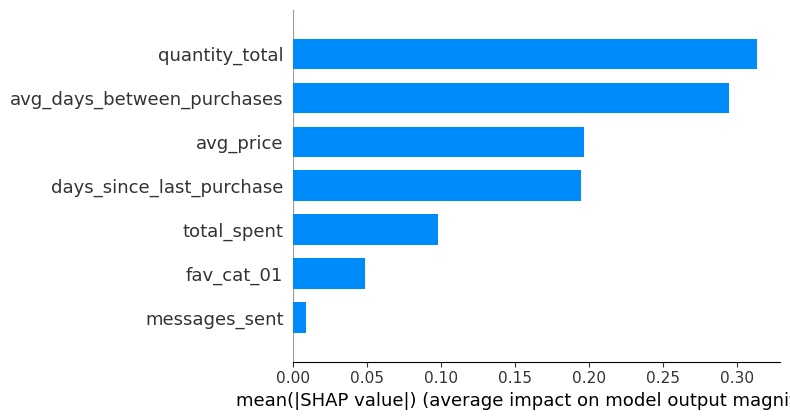

In [197]:
# трансформируем данные с помощью препроцессора
X_train_transformed = preprocessor.transform(X_train)

# TreeExplainer для бустингов
if isinstance(model, (CatBoostClassifier, XGBClassifier, LGBMClassifier)):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_train_transformed)

# KernelExplainer для остальных моделей
else:
    explainer = shap.KernelExplainer(model.predict_proba, X_train_transformed)
    shap_values = explainer.shap_values(X_train_transformed)

shap.summary_plot(shap_values, X_train_transformed, plot_type='bar', feature_names=X_train.columns)


## Итоги

Мы получили задачу создать модель для прогнозирования покупки покупателем в ближайший обозначенный период. Для интернет-магазина это необходимо, чтобы повысить эффективность своей маркетинговой работы.

Данные для обучения наших моделей мы получили в виде датасетов, описывающих покупки и сообщения клиентам от разных каналов. Целевой признак был выдан отдельным датасетом, представлял из себя значения 0\1 - означающим, что клиент за определенный период(90 дней) не совершал или совершал покупку, задача классификации.

Датасеты были частично предобработаны, так как напрямую не использовались в тренировке моделей. Анализ выявил большое число дубликатов в предоставленных таблицах о покупках и сообщениях. Однако при более детальном рассмотрении их одинаковость не была подтверждена, и дубликаты были сохранены. Это также стало причиной дисбаланса классов целевого признака. Выбросы удалены.

Важной особенностью этой работы было создание тренировочного датасета из имеющихся данных о покупка apparel-purchase и apparel-messages. Были созданы такие признаки как:
* общее число сообщений (отправленное клиенту)
* число покупок
* сумма потраченных средств
* средняя цена покупки
* средний период покупок
* дней с последней покупки
* любимые категории
Стратификация целевого признака при разбиении на тренировочную и тестовую выборки помогло повысить метрику.
Перебором гиперпараметров на GridSearch (за ~5минут) мы получили наивысшую метрику **ROC-AUC 0.72** на модели **CatBoost**.

Анализ входных признаков показал, что наибольший вес имеют признаки (в порядке влияния):
* число покупок
* средний период покупок
* средняя цена покупки
* дней с последней покупки

Меньше влияют признаки Самая частая категория (верхнеуровневая) и Сумма потраченных средств. Количество отправленных сообщений - наименее влиятельный признак.

Рекомендации для маркетинга:
* Добавить время совершения покупок
* Восполнить недостающие записи в сообщениях о совершенных поку
* Так как число сообщений не оказывает или почти не оказывает влияния на поведение клиента, стоит обратить внимание маркетингово отдела на этот аспект.х
* 